# **Выделение групп пользователей на основе поведения**

### **Описание данных:**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.


***Необходимо выделить группы пользователей**, различающиеся по продуктовым метрикам:

- retention rate, 
- время в приложении, 
- частота совершения событий, 
- конверсия в целевое действие `contacts_show` 

Датасет **mobile_dataset.csv** содержит колонки:

`event.time` — время совершения

`event.name` — название события

`user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:

`userId` — идентификатор пользователя

`source` — источник, с которого пользователь установил приложение

Расшифровки событий:

`advert_open` — открытие карточки объявления

`photos_show` — просмотр фотографий в объявлении

`tips_show` — пользователь увидел рекомендованные объявления

`tips_click` — пользователь кликнул по рекомендованному объявлению

`contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления

`contacts_call` — пользователь позвонил по номеру телефона на карточке объявления

`map` — пользователь открыл карту размещенных объявлений

`search_1` — `search_7` — разные события, связанные с поиском по сайту

`favorites_add` — добавление объявления в избранное



### **Декомпозиция:**



1. Импорт библиотек и загрузка данных, первичный осмотр *(проверка на пропуски и корректность наименований колонок/переименование)*

2. Предобработка и исследование данных *(замена типов данных, проверка на дубликаты, осмотр строковых данных на скрытые дубликаты, числовых данных на выбросы/распределение)*

3. EDA
    
    3.1 Retention Rate (выделение пользовательских сессий сделаем здесь, используем ниже)
    
    3.2 Время в приложении
    
    3.3 Распределение событий по времени
    
    3.4 Количество событий по пользователям
        
    3.5 Конверсия в целевое действие (пользующиеся самостоятельным поиском)
    
    3.6 Конверсия в целевое действие (пользующиеся самостоятельным рекомендациями) 
    
    
4. Сегментация пользователей

    4.1 Выделение групп пользователей на основании их действий
    
    4.2 Расчет метрик для сегментированных пользователей
    
    4.3 Выводы

5. Проверка статистических гипотез

    5.1 Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. ***Проверка гипотезы: две эти группы демонстрируют разную конверсию в просмотры контактов***.
    
    5.2  ***Среднее время, проведенное в приложении, у групп пользователей ,совершивших целевое действие(просмотр контактов) и не совершивших его, различается***.
    
6. Презентация/дэшборд

<a id='content'></a>
# Содержание

1. [Импорт библиотек и загрузка данных](#part1)

2. [Предобработка данных](#part2)

    2.1 [Замена типов данных](#part21)
    
    2.2 [Дубликаты](#part22)
    
    2.3 [Исследование данных](#part23)
    
    2.3.1 [Датасет mobile_sources](#part231)
    
    2.3.1.1 [Столбец user_id](#part2311)
        
    2.3.1.2 [Столбец source](#part2312)
        
    2.3.2 [Датасет mobile_dataset](#part232)
    
    2.3.2.1 [Столбец time](#part2321)
    
    2.3.2.2 [Столбец event](#part2322)
        
    2.3.2.3 [Столбец user_id](#part2323)
        
    2.3.3 [Датасет df общий](#part233)
    
    2.4 [Выводы](#part24)
    
3. [EDA](#part3)

    3.1 [Retantion Rate (выделение сессий)](#part31)
    
    3.2 [Время в приложении](#part32)
    
    3.3 [Распределение событий](#part33)
    
    3.4 [События по пользователям)](#part34)
    
    3.5 [Конверсия в целевое (поиск)](#part35)
    
    3.6 [Конверсия в целевое (рекомендации)](#part36)
    
4. [Сегментация пользователей](#part4)

    4.1 [Расчет метрик](#part41)
    
    4.2 [Группа по source](#part42)
    
    4.3 [Группа по contacts_call](#part43)
    
    4.4 [Группа по search](#part44)
    
    4.5 [Группа по tips_click](#part45)
    
    4.6 [Группа по advert_open](#part46)
    
    4.7 [Группа по tips_show](#part47)
    
    4.8 [Группа по map](#part48)
    
    4.9 [Выводы](#part49)
    
5. [Проверка гипотез](#part5)

    5.1 [Гипотеза 1](#part51)
    
    5.2 [Гипотеза 2](#part52)
    
6. [Выводы и рекомендации](#part6)

7. [Презентация и дэшборд](#part7)


<a id='part1'></a>
## Импорт библиотек и загрузка данных

[*Назад к оглавлению*](#content)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime as dt
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats as st
import math as mth
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [2]:
mobile_sourсes, mobile_dataset = (
    pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv'), 
    pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
)

In [3]:
for data in [mobile_sourсes, mobile_dataset]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None



Пропуски в данных отсутствуют, заменим тип данных во втором датасете на datetime

In [4]:
for data in [mobile_sourсes, mobile_dataset]: 
    display(data.head())

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894  other 
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb  other 
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320  tips_show     
2  2019-10-07 00:00:02.245341  tips_show     
3  2019-10-07 00:00:07.039334  tips_show     
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [5]:
mobile_sourсes.columns = ['user_id', 'source']
mobile_dataset.columns = ['time', 'event', 'user_id']

In [6]:
for data in [mobile_sourсes, mobile_dataset]: 
    display(data.head())

user_id  source
0  020292ab-89bc-4156-9acf-68bc2783f894  other 
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb  other 
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

time        event  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320  tips_show     
2  2019-10-07 00:00:02.245341  tips_show     
3  2019-10-07 00:00:07.039334  tips_show     
4  2019-10-07 00:00:56.319813  advert_open   

                                user_id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<a id='part2'></a>
## Предобработка данных

[*Назад к оглавлению*](#content)

<a id='part21'></a>
### Замена типов данных

[*Назад к оглавлению*](#content)

In [7]:
mobile_dataset['time'] = mobile_dataset['time'].astype('datetime64')

mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   time     74197 non-null  datetime64[ns]
 1   event    74197 non-null  object        
 2   user_id  74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


<a id='part22'></a>
### Дубликаты

[*Назад к оглавлению*](#content)

In [8]:
for data in [mobile_sourсes, mobile_dataset]: 
    print('Кол-во дубликатов =',data.duplicated().sum(), end='\n\n')

Кол-во дубликатов = 0

Кол-во дубликатов = 0



Дубликаты также отсутствуют, посмотрим на сами данные

<a id='part23'></a>
### Исследование данных

[*Назад к оглавлению*](#content)

<a id='part231'></a>
#### Датасет `mobile_sourсes`

[*Назад к оглавлению*](#content)

In [9]:
mobile_sourсes.head(3)

user_id  source
0  020292ab-89bc-4156-9acf-68bc2783f894  other 
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex

<a id='part2311'></a>
##### Столбец `user_id`

[*Назад к оглавлению*](#content)

Определим, все ли идентификаторы пользователей уникальны

In [10]:
print(f'Количество строк в датасете - {len(mobile_sourсes)} \nСреди них уникальных идентификаторов - {mobile_sourсes["user_id"].nunique()}')

Количество строк в датасете - 4293 
Среди них уникальных идентификаторов - 4293


<a id='part2312'></a>
##### Столбец `source`

[*Назад к оглавлению*](#content)

In [11]:
mobile_sourсes['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

Имеем три источника, все пользователи уникальны, датасет не требует дальнейших вмешательств

<a id='part232'></a>
#### Датасет `mobile_dataset`

[*Назад к оглавлению*](#content)

In [12]:
mobile_dataset.head(3)

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:02.245341  tips_show     

                                user_id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<a id='part2321'></a>
##### Столбец `time`

[*Назад к оглавлению*](#content)

In [13]:
mobile_dataset['time'].describe()

count     74197                     
unique    74197                     
top       2019-10-19 18:36:07.773802
freq      1                         
first     2019-10-07 00:00:00.431357
last      2019-11-03 23:58:12.532487
Name: time, dtype: object

Определим временной период, данными в котором мы располагаем

In [14]:
print('Имеем данные за временной период:', (mobile_dataset['time'].max() - mobile_dataset['time'].min()))

Имеем данные за временной период: 27 days 23:58:12.101130


Таким образом, видим: данные за период с 7.10.2019 по 3.11.2019, всего у нас практически 28 дней

<a id='part2322'></a>
##### Столбец `event`

[*Назад к оглавлению*](#content)

In [15]:
mobile_dataset['event'].value_counts()

tips_show        40055
photos_show      10012
advert_open      6164 
contacts_show    4450 
map              3881 
search_1         3506 
favorites_add    1417 
search_5         1049 
tips_click       814  
search_4         701  
contacts_call    541  
search_3         522  
search_6         460  
search_2         324  
search_7         222  
show_contacts    79   
Name: event, dtype: int64

Видим повторяющией события, записанные по-разному: `show_contacts` и `contacts_show`(целевое событие), `search_1` - `search_7`(события поиска). Приведем все к единообразию

In [16]:
def replace_event_name(event):
    if 'show_contacts' in event:
        return "contacts_show"
    if 'search_' in event:
        return "search"
    else:
        return event

In [17]:
mobile_dataset['event'] = mobile_dataset['event'].apply(replace_event_name)
mobile_dataset['event'].value_counts()

tips_show        40055
photos_show      10012
search           6784 
advert_open      6164 
contacts_show    4529 
map              3881 
favorites_add    1417 
tips_click       814  
contacts_call    541  
Name: event, dtype: int64



**Самыми частыми событиями** являются `tips_show` (юзер увидел рекомендованные объявления) и `photos_show` (юзер посмотрел фотографии в объявлении).
**Самыми редкими событиями** являются `tips_click` (юзер кликнул по рекомендованному объявлению) и `contacts_call` (юзер позвонил по номеру телефона на карточке объявления).
Таким образом, очевидно, что рекомендованные объявления в подавляющем большинстве остаются без внимания.

<a id='part2323'></a>
##### Столбец `user_id`

[*Назад к оглавлению*](#content)

Сверим количество уникальных пользователей с датасетом `mobile_sourсes` (там их было 4293) и все ли они совпадают

In [18]:
print('Кол-во уникальных пользователей равно',mobile_dataset['user_id'].nunique())

Кол-во уникальных пользователей равно 4293


In [19]:
if set(mobile_sourсes['user_id']) == set(mobile_dataset['user_id']):
    print('Множества идентификаторов совпадают')
else:
    print('Множества идентификаторов не совпадают')

Множества идентификаторов совпадают



    
Таким образом видим, что **идентификаторы юзеров совпадают**, как по количеству, так и "по качеству". Оставляем столбец.

<a id='part233'></a>
#### Датасет `df` (общий)

[*Назад к оглавлению*](#content)

Сведем оба датасета воедино, дальнейшую работу будем вести с ним

In [20]:
df = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:02.245341  tips_show     
3 2019-10-07 00:00:07.039334  tips_show     
4 2019-10-07 00:00:56.319813  advert_open   

                                user_id  source  
0  020292ab-89bc-4156-9acf-68bc2783f894  other   
1  020292ab-89bc-4156-9acf-68bc2783f894  other   
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex  
3  020292ab-89bc-4156-9acf-68bc2783f894  other   
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex

Проверим общий датасет на дубликаты

In [21]:
df.duplicated().sum()

0

Удостоверимся, что у нас одинаково полные данные за весь период

In [22]:
print('Перед нами логи за период с {} по {}.'.format(df['time'].min(), df['time'].max()))

Перед нами логи за период с 2019-10-07 00:00:00.431357 по 2019-11-03 23:58:12.532487.


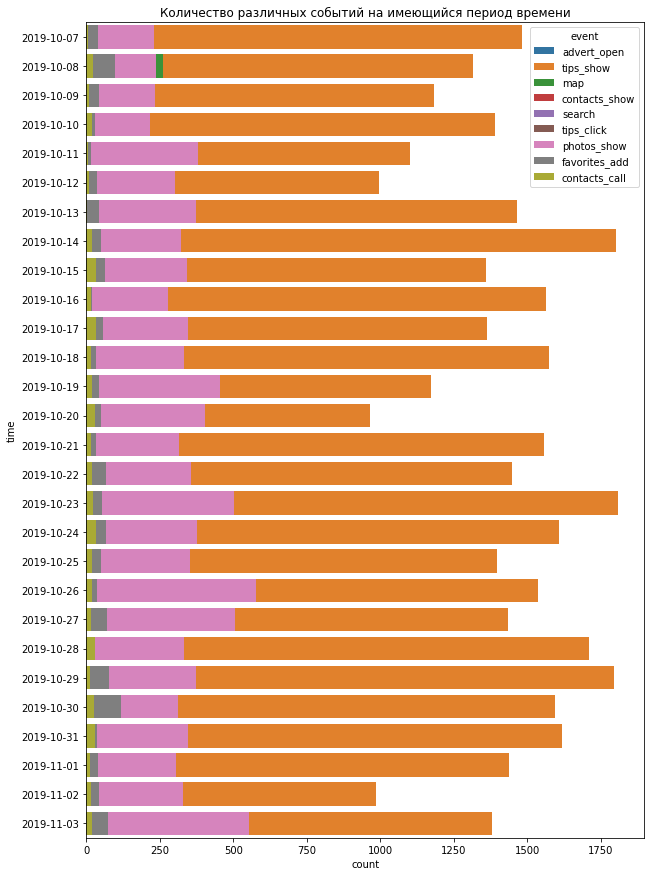

In [23]:
plt.figure(figsize=(10, 15))
ax = sns.countplot(y=df['time'].dt.strftime('%Y-%m-%d'), 
                   hue='event', 
                   data=df, 
                   dodge=False)
ax.set_title('Количество различных событий на имеющийся период времени')
plt.show()

Исходя из гистограммы по дате, видим, что одинаково полные данные имеются за полный исследуемый период 

Посмотрим на распределение пользовательской активности

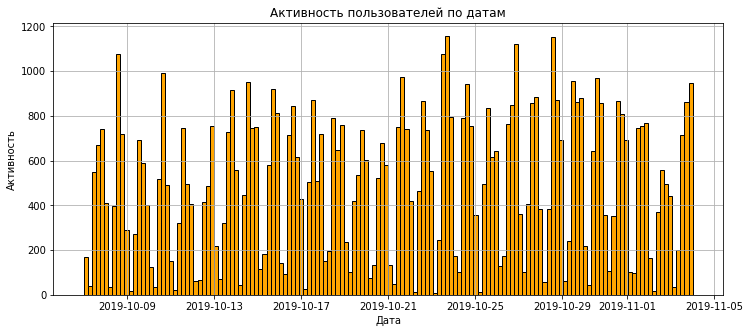

In [24]:
df['time'].hist(figsize=(12,5), color='orange',  edgecolor = 'black', bins=150) 
plt.title('Активность пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Активность')
plt.show()

Данные по активности пользователей распределены достаточно равномерно, оставляем. Проверим распределение событий по юзерам. Сгруппируем по уникальным и посмотрим, сколько на каждого из них приходится событий.

In [25]:
user_events = df.pivot_table(index='user_id', values='event',aggfunc='count')
user_events.describe()

event
count  4293.000000
mean   17.283252  
std    29.130677  
min    1.000000   
25%    5.000000   
50%    9.000000   
75%    17.000000  
max    478.000000

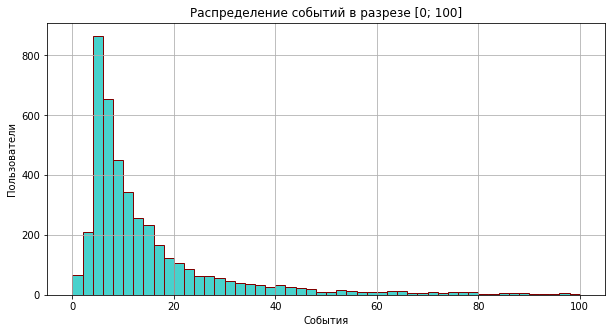

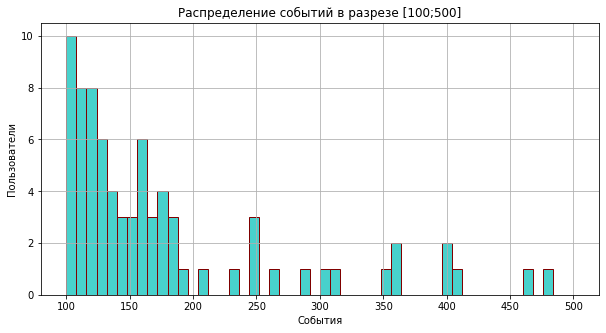

In [26]:
user_events.hist(figsize=(10,5), color = 'mediumturquoise', edgecolor='maroon', bins=50, range=(0,100))
plt.xlabel('События')
plt.ylabel('Пользователи')
plt.title('Распределение событий в разрезе [0; 100]')
plt.show()

user_events.hist(figsize=(10,5), color = 'mediumturquoise', edgecolor='maroon', bins=50, range=(100,500))
plt.xlabel('События')
plt.ylabel('Пользователи')
plt.title('Распределение событий в разрезе [100;500]')
plt.show()


Видим, что распределение достаточно неравномерное, среднее количество событий на человека в месяц (точнее 28 дней) составляет 17, медиана 9, присутствуют выбросы аж до 478 событий на человека (видимо, для кого-то приложение является достаточно популярным, порадуемся за него и за нас =) ). В целом данные похожи на правду. Делаем выводы и идем дальше

<a id='part24'></a>
### Выводы

[*Назад к оглавлению*](#content)



В нашем распоряжении оказалось 2 датасета:
    
 `mobile_dataset` - **74197 строки, 3 столбца** - данные о идентификаторах пользователей, времени совершения событий и типе событий. 
    
 `mobile_sources` - **4293 строки, 2 столбца** - данные об идентификаторах пользователей и об источниках, с которых пользователи устанавливают приложение.

В обоих датасетах **отсутствуют пропуски и дубликаты**. Тип данных `event_time` заменили на *datetime*.

Тажк изменены названия столбцов и типы событий приведены к единообразию в части целевого события (*contacts_show*) и в части поиска (*search*).

Выявлено, что **идентификаторы пользователей уникальны в обоих датасетах**, соответствуют друг другу количественно и "качественно".

Определен временной промежуток, данными за который мы располагаем - **данные за период с 7.10.2019 по 3.11.2019**, всего у нас практически 28 дней, данные полные.

Оба датасета объеденены в один `df`, также проверен на дубликаты (отсутствуют).

Выяснили, что **в среднем на пользователя приходится 17 событий** (медианное значение 9). Из гистограмм видим, что выбросов много и они доходят до 478 событий на пользователя за 28 дней (кто-то очень активный), их удаление чревато потерей данных, можено сделать вывод, что данные похожи на правду.

<a id='part3'></a>
## EDA

[*Назад к оглавлению*](#content)

<a id='part31'></a>
### Retantion Rate

[*Назад к оглавлению*](#content)

Выделим сессии юзеров относительно тайм-аута (между событиями время больше определенного порога (30 мин) - разные сессии)

In [27]:
df.sort_values(['user_id', 'time'])
g = (df.groupby('user_id')['time'].diff() > pd.Timedelta('30Min')).cumsum()
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
#df.sort_values(['user_id', 'time'])
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:02.245341  tips_show     
3 2019-10-07 00:00:07.039334  tips_show     
4 2019-10-07 00:00:56.319813  advert_open   

                                user_id  source  session_id  
0  020292ab-89bc-4156-9acf-68bc2783f894  other   1           
1  020292ab-89bc-4156-9acf-68bc2783f894  other   1           
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex  2           
3  020292ab-89bc-4156-9acf-68bc2783f894  other   1           
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex  2

Для формирования когорт определим событие и период — на их основе сформируем когорту. 
Для этого нам следует определить дату и время первого посещения юзера и добавить в исходный датасет `df`

In [28]:
first_ts = df.groupby(['user_id'])['time'].min()
first_ts.name = 'first_ts'
df = df.merge(first_ts, on='user_id', how='outer') 
df['dt'] = df['first_ts'].dt.strftime('%Y-%m-%d')
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     
3 2019-10-07 00:01:27.770232  advert_open   
4 2019-10-07 00:01:34.804591  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
3  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
4  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  
0 2019-10-07 00:00:00.431357  2019-10-07  
1 2019-10-07 00:00:00.431357  2019-10-07  
2 2019-10-07 00:00:00.431357  2019-10-07  
3 2019-10-07 00:00:00.431357  2019-10-07  
4 2019-10-07 00:00:00.431357  2019-10-07

In [29]:
# вычисляем лайфтайм в днях

df['lifetime'] = (df['time'] - df['first_ts']).dt.days
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     
3 2019-10-07 00:01:27.770232  advert_open   
4 2019-10-07 00:01:34.804591  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
3  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
4  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  lifetime  
0 2019-10-07 00:00:00.431357  2019-10-07  0         
1 2019-10-07 00:00:00.431357  2019-10-07  0         
2 2019-10-07 00:00:00.431357  2019-10-07  0         
3 2019-10-07 00:00:00.431357  2019-10-07  0         
4 2019-10-07 00:00:00.431357  2019-10-07  0

Далее по плану — таблица удержания. 

Применим метод pivot_table(). Чтобы сделать даты первого посещения заголовками строк, лайфтаймы — заголовками столбцов, а количество уникальных пользователей — значениями, передадим параметру index значения столбца dt, параметру columns — значения lifetime, параметру values — значения user_id, а параметру aggfunc — функцию для подсчёта уникальных значений nunique.

In [30]:
# строим таблицу удержания

df_grouped = df.pivot_table(
    index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
)

df_grouped

lifetime        0     1     2     3     4     5     6     7     8     9  ...  \
dt                                                                       ...   
2019-10-07  204.0  25.0  20.0  22.0  11.0  8.0   12.0  16.0  11.0  10.0  ...   
2019-10-08  167.0  27.0  21.0  9.0   7.0   11.0  9.0   12.0  10.0  7.0   ...   
2019-10-09  176.0  13.0  11.0  10.0  12.0  12.0  10.0  13.0  11.0  6.0   ...   
2019-10-10  174.0  16.0  18.0  14.0  17.0  14.0  12.0  9.0   14.0  6.0   ...   
2019-10-11  136.0  12.0  16.0  13.0  12.0  10.0  10.0  6.0   2.0   6.0   ...   
2019-10-12  125.0  16.0  20.0  7.0   8.0   11.0  10.0  11.0  10.0  8.0   ...   
2019-10-13  148.0  19.0  10.0  8.0   10.0  8.0   8.0   7.0   7.0   7.0   ...   
2019-10-14  185.0  21.0  19.0  19.0  15.0  13.0  10.0  8.0   14.0  7.0   ...   
2019-10-15  186.0  26.0  17.0  15.0  10.0  10.0  15.0  14.0  12.0  4.0   ...   
2019-10-16  166.0  21.0  12.0  5.0   8.0   10.0  7.0   9.0   10.0  7.0   ...   
2019-10-17  170.0  24.0  22.0  15.0  15.0  16.0  16.0  8.0   8.0   7.0   ...   
2019-10-18  156.0  13.0  15.0  15.0  9.0   10.0  10.0  12.0  11.0  5.0   ...   
2019-10-19  159.0  15.0  18.0  11.0  4.0   9.0   10.0  10.0  5.0   7.0   ...   
2019-10-20  144.0  15.0  11.0  7.0   10.0  9.0   6.0   10.0  8.0   4.0   ...   
2019-10-21  161.0  15.0  14.0  17.0  7.0   6.0   8.0   15.0  6.0   4.0   ...   
2019-10-22  157.0  18.0  13.0  8.0   6.0   9.0   9.0   11.0  9.0   8.0   ...   
2019-10-23  189.0  18.0  15.0  14.0  10.0  10.0  9.0   11.0  5.0   5.0   ...   
2019-10-24  162.0  17.0  12.0  8.0   10.0  10.0  11.0  5.0   7.0   8.0   ...   
2019-10-25  147.0  13.0  14.0  15.0  14.0  9.0   10.0  10.0  7.0   3.0   ...   
2019-10-26  139.0  21.0  9.0   10.0  12.0  8.0   10.0  4.0   5.0  NaN    ...   
2019-10-27  139.0  10.0  10.0  10.0  11.0  12.0  9.0   6.0  NaN   NaN    ...   
2019-10-28  158.0  15.0  15.0  9.0   9.0   2.0   4.0  NaN   NaN   NaN    ...   
2019-10-29  135.0  23.0  17.0  13.0  8.0   3.0  NaN   NaN   NaN   NaN    ...   
2019-10-30  134.0  19.0  10.0  8.0   3.0  NaN   NaN   NaN   NaN   NaN    ...   
2019-10-31  132.0  12.0  6.0   3.0  NaN   NaN   NaN   NaN   NaN   NaN    ...   
2019-11-01  112.0  11.0  3.0  NaN   NaN   NaN   NaN   NaN   NaN   NaN    ...   
2019-11-02  97.0   10.0 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    ...   
2019-11-03  135.0 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    ...   

lifetime      17   18   19   20   21   22   23   24   25   26  
dt                                                             
2019-10-07  4.0   9.0  5.0  3.0  4.0  7.0  7.0  8.0  9.0  6.0  
2019-10-08  5.0   3.0  8.0  6.0  3.0  4.0  7.0  5.0  4.0  2.0  
2019-10-09  3.0   2.0  5.0  2.0  6.0  2.0  1.0  4.0  3.0 NaN   
2019-10-10  11.0  6.0  5.0  3.0  7.0  3.0  2.0  2.0 NaN  NaN   
2019-10-11  8.0   4.0  3.0  3.0  4.0  4.0  2.0 NaN  NaN  NaN   
2019-10-12  5.0   5.0  3.0  3.0  8.0  4.0 NaN  NaN  NaN  NaN   
2019-10-13  2.0   3.0  2.0  5.0  1.0 NaN  NaN  NaN  NaN  NaN   
2019-10-14  7.0   4.0  3.0  1.0 NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-15  6.0   5.0  3.0 NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-16  2.0   1.0 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-17  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-18 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-19 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-20 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-21 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-22 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-23 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-24 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-25 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-26 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-27 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-28 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2019-10-29 NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

**АЛЯРМА** ***Здесь мы видим, что в когорте от 7 октября (и многих других дат) на 3,6...18, 25 лайфтайм юзеров больше, чем на предыдущий, это кривизна данных?!.***

Следующий шаг — вычислить размеры когорт. Сгруппируем данные по дате первого посещения из dt и посчитаем количество уникальных пользователей в каждой когорте, применив функцию nunique к столбцу user_id. Столбец с результатами переименуем в соответствии с содержанием в cohort_size — размер когорты.

In [31]:
cohort_sizes = (
    df.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes

cohort_size
dt                     
2019-10-07  204        
2019-10-08  167        
2019-10-09  176        
2019-10-10  174        
2019-10-11  136        
2019-10-12  125        
2019-10-13  148        
2019-10-14  185        
2019-10-15  186        
2019-10-16  166        
2019-10-17  170        
2019-10-18  156        
2019-10-19  159        
2019-10-20  144        
2019-10-21  161        
2019-10-22  157        
2019-10-23  189        
2019-10-24  162        
2019-10-25  147        
2019-10-26  139        
2019-10-27  139        
2019-10-28  158        
2019-10-29  135        
2019-10-30  134        
2019-10-31  132        
2019-11-01  112        
2019-11-02  97         
2019-11-03  135

Объединим таблицу размеров когорт с таблицей удержания по столбцу dt методом merge(). Отсутствующие значения NaN заменим на 0 методом fillna()

In [32]:
# объединяем размеры когорт и таблицу удержания

df_grouped = cohort_sizes.merge(
    df_grouped, on='dt', how='left'
).fillna(0)

df_grouped

cohort_size      0     1     2     3     4     5     6     7  \
dt                                                                         
2019-10-07  204          204.0  25.0  20.0  22.0  11.0  8.0   12.0  16.0   
2019-10-08  167          167.0  27.0  21.0  9.0   7.0   11.0  9.0   12.0   
2019-10-09  176          176.0  13.0  11.0  10.0  12.0  12.0  10.0  13.0   
2019-10-10  174          174.0  16.0  18.0  14.0  17.0  14.0  12.0  9.0    
2019-10-11  136          136.0  12.0  16.0  13.0  12.0  10.0  10.0  6.0    
2019-10-12  125          125.0  16.0  20.0  7.0   8.0   11.0  10.0  11.0   
2019-10-13  148          148.0  19.0  10.0  8.0   10.0  8.0   8.0   7.0    
2019-10-14  185          185.0  21.0  19.0  19.0  15.0  13.0  10.0  8.0    
2019-10-15  186          186.0  26.0  17.0  15.0  10.0  10.0  15.0  14.0   
2019-10-16  166          166.0  21.0  12.0  5.0   8.0   10.0  7.0   9.0    
2019-10-17  170          170.0  24.0  22.0  15.0  15.0  16.0  16.0  8.0    
2019-10-18  156          156.0  13.0  15.0  15.0  9.0   10.0  10.0  12.0   
2019-10-19  159          159.0  15.0  18.0  11.0  4.0   9.0   10.0  10.0   
2019-10-20  144          144.0  15.0  11.0  7.0   10.0  9.0   6.0   10.0   
2019-10-21  161          161.0  15.0  14.0  17.0  7.0   6.0   8.0   15.0   
2019-10-22  157          157.0  18.0  13.0  8.0   6.0   9.0   9.0   11.0   
2019-10-23  189          189.0  18.0  15.0  14.0  10.0  10.0  9.0   11.0   
2019-10-24  162          162.0  17.0  12.0  8.0   10.0  10.0  11.0  5.0    
2019-10-25  147          147.0  13.0  14.0  15.0  14.0  9.0   10.0  10.0   
2019-10-26  139          139.0  21.0  9.0   10.0  12.0  8.0   10.0  4.0    
2019-10-27  139          139.0  10.0  10.0  10.0  11.0  12.0  9.0   6.0    
2019-10-28  158          158.0  15.0  15.0  9.0   9.0   2.0   4.0   0.0    
2019-10-29  135          135.0  23.0  17.0  13.0  8.0   3.0   0.0   0.0    
2019-10-30  134          134.0  19.0  10.0  8.0   3.0   0.0   0.0   0.0    
2019-10-31  132          132.0  12.0  6.0   3.0   0.0   0.0   0.0   0.0    
2019-11-01  112          112.0  11.0  3.0   0.0   0.0   0.0   0.0   0.0    
2019-11-02  97           97.0   10.0  0.0   0.0   0.0   0.0   0.0   0.0    
2019-11-03  135          135.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0    

               8  ...    17   18   19   20   21   22   23   24   25   26  
dt                ...                                                     
2019-10-07  11.0  ...  4.0   9.0  5.0  3.0  4.0  7.0  7.0  8.0  9.0  6.0  
2019-10-08  10.0  ...  5.0   3.0  8.0  6.0  3.0  4.0  7.0  5.0  4.0  2.0  
2019-10-09  11.0  ...  3.0   2.0  5.0  2.0  6.0  2.0  1.0  4.0  3.0  0.0  
2019-10-10  14.0  ...  11.0  6.0  5.0  3.0  7.0  3.0  2.0  2.0  0.0  0.0  
2019-10-11  2.0   ...  8.0   4.0  3.0  3.0  4.0  4.0  2.0  0.0  0.0  0.0  
2019-10-12  10.0  ...  5.0   5.0  3.0  3.0  8.0  4.0  0.0  0.0  0.0  0.0  
2019-10-13  7.0   ...  2.0   3.0  2.0  5.0  1.0  0.0  0.0  0.0  0.0  0.0  
2019-10-14  14.0  ...  7.0   4.0  3.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-15  12.0  ...  6.0   5.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-16  10.0  ...  2.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-17  8.0   ...  1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-18  11.0  ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-19  5.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-20  8.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-21  6.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-22  9.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-23  5.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-24  7.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-25  7.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-26  5.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-27  0.0   ...  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-1

Рассчитаем коэффициенты удержания. Для этого вызовем функцию div(), выполняющую деление. Передадим ей столбец cohort_size в качестве делителя и параметр axis, равный нулю.
Столбец cohort_size пока не понадобится — удалим его методом drop()

In [33]:
# делим данные таблицы удержания на размеры когорт

df_grouped = df_grouped.div(
    df_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

df_grouped

0         1         2         3         4         5         6  \
dt                                                                            
2019-10-07  1.0  0.122549  0.098039  0.107843  0.053922  0.039216  0.058824   
2019-10-08  1.0  0.161677  0.125749  0.053892  0.041916  0.065868  0.053892   
2019-10-09  1.0  0.073864  0.062500  0.056818  0.068182  0.068182  0.056818   
2019-10-10  1.0  0.091954  0.103448  0.080460  0.097701  0.080460  0.068966   
2019-10-11  1.0  0.088235  0.117647  0.095588  0.088235  0.073529  0.073529   
2019-10-12  1.0  0.128000  0.160000  0.056000  0.064000  0.088000  0.080000   
2019-10-13  1.0  0.128378  0.067568  0.054054  0.067568  0.054054  0.054054   
2019-10-14  1.0  0.113514  0.102703  0.102703  0.081081  0.070270  0.054054   
2019-10-15  1.0  0.139785  0.091398  0.080645  0.053763  0.053763  0.080645   
2019-10-16  1.0  0.126506  0.072289  0.030120  0.048193  0.060241  0.042169   
2019-10-17  1.0  0.141176  0.129412  0.088235  0.088235  0.094118  0.094118   
2019-10-18  1.0  0.083333  0.096154  0.096154  0.057692  0.064103  0.064103   
2019-10-19  1.0  0.094340  0.113208  0.069182  0.025157  0.056604  0.062893   
2019-10-20  1.0  0.104167  0.076389  0.048611  0.069444  0.062500  0.041667   
2019-10-21  1.0  0.093168  0.086957  0.105590  0.043478  0.037267  0.049689   
2019-10-22  1.0  0.114650  0.082803  0.050955  0.038217  0.057325  0.057325   
2019-10-23  1.0  0.095238  0.079365  0.074074  0.052910  0.052910  0.047619   
2019-10-24  1.0  0.104938  0.074074  0.049383  0.061728  0.061728  0.067901   
2019-10-25  1.0  0.088435  0.095238  0.102041  0.095238  0.061224  0.068027   
2019-10-26  1.0  0.151079  0.064748  0.071942  0.086331  0.057554  0.071942   
2019-10-27  1.0  0.071942  0.071942  0.071942  0.079137  0.086331  0.064748   
2019-10-28  1.0  0.094937  0.094937  0.056962  0.056962  0.012658  0.025316   
2019-10-29  1.0  0.170370  0.125926  0.096296  0.059259  0.022222  0.000000   
2019-10-30  1.0  0.141791  0.074627  0.059701  0.022388  0.000000  0.000000   
2019-10-31  1.0  0.090909  0.045455  0.022727  0.000000  0.000000  0.000000   
2019-11-01  1.0  0.098214  0.026786  0.000000  0.000000  0.000000  0.000000   
2019-11-02  1.0  0.103093  0.000000  0.000000  0.000000  0.000000  0.000000   
2019-11-03  1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                   7         8         9  ...        17        18        19  \
dt                                        ...                                 
2019-10-07  0.078431  0.053922  0.049020  ...  0.019608  0.044118  0.024510   
2019-10-08  0.071856  0.059880  0.041916  ...  0.029940  0.017964  0.047904   
2019-10-09  0.073864  0.062500  0.034091  ...  0.017045  0.011364  0.028409   
2019-10-10  0.051724  0.080460  0.034483  ...  0.063218  0.034483  0.028736   
2019-10-11  0.044118  0.014706  0.044118  ...  0.058824  0.029412  0.022059   
2019-10-12  0.088000  0.080000  0.064000  ...  0.040000  0.040000  0.024000   
2019-10-13  0.047297  0.047297  0.047297  ...  0.013514  0.020270  0.013514   
2019-10-14  0.043243  0.075676  0.037838  ...  0.037838  0.021622  0.016216   
2019-10-15  0.075269  0.064516  0.021505  ...  0.032258  0.026882  0.016129   
2019-10-16  0.054217  0.060241  0.042169  ...  0.012048  0.006024  0.000000   
2019-10-17  0.047059  0.047059  0.041176  ...  0.005882  0.000000  0.000000   
2019-10-18  0.076923  0.070513  0.032051  ...  0.000000  0.000000  0.000000   
2019-10-19  0.062893  0.031447  0.044025  ...  0.000000  0.000000  0.000000   
2019-10-20  0.069444  0.055556  0.027778  ...  0.000000  0.000000  0.000000   
2019-10-21  0.093168  0.037267  0.024845  ...  0.000000  0.000000  0.000000   
2019-10-22  0.070064  0.057325  0.050955  ...  0.000000  0.000000  0.000000   
2019-10-23  0.058201  0.026455  0.026455  ...  0.000000  0.000000  0.000000   
2019-10-24  0.030864  0.043210  0.049383  ...  0.000000  0.000000  0.000000   
2019-10-25  0.068027  0.047619  0.020408  ...  0.000000  0.0000


    
***Retention Rate*** пользователей, пришедших в исследуемый нами период времени ***рассчитан***. Построим хитмэп без нулевого лайфтайма

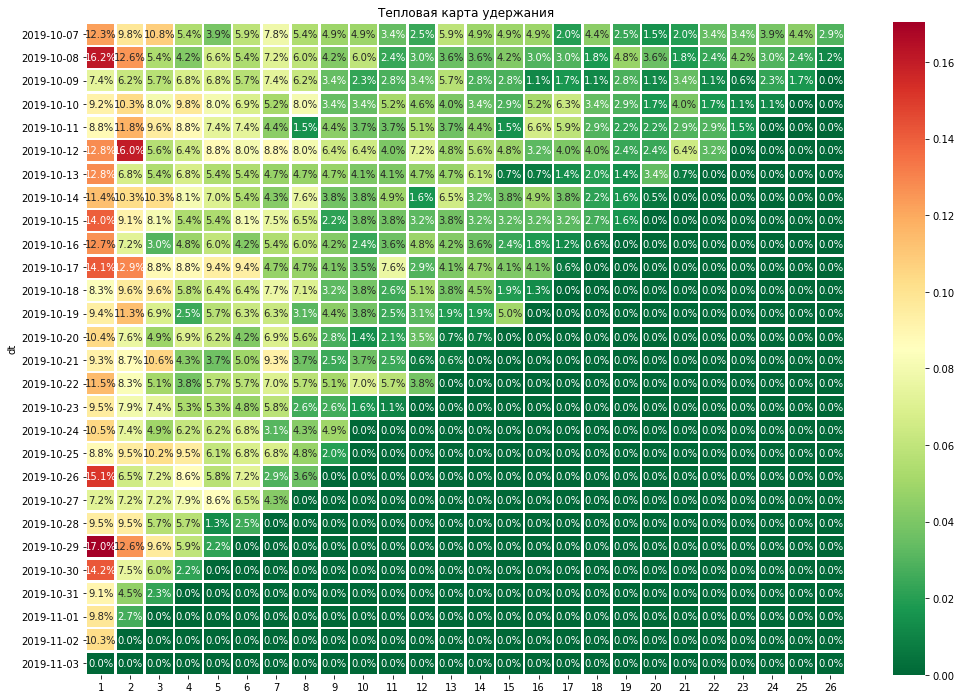

In [34]:
plt.figure(figsize=(17, 12))  # задаём размер графика
sns.heatmap(
    df_grouped.drop(columns=0),  # удаляем размеры когорт
    cmap='RdYlGn_r', linewidths=1.5,
    annot=True,  # включаем подписи
    fmt='.1%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()



Видим воочию эти странные скачки удержания, так быть не должно в нормальных данных, уповаю на кривые исходные данные. Ретеншн не блещет здоровьем, **максимальное значение** на второй день у когорты от 29 октября **составляет 17%**. Самые **маленькие значения** показателя у когорт от и 27 октября (**7,4 и 7,2 %%** соответственно)
Если анализировать то, что получилось, становится ясно, что *самый высокий коэффициент удержания у когорт от 08, 26 и 29 октября*.

Посмотрим на кривых удержания и удержаиня в динамике


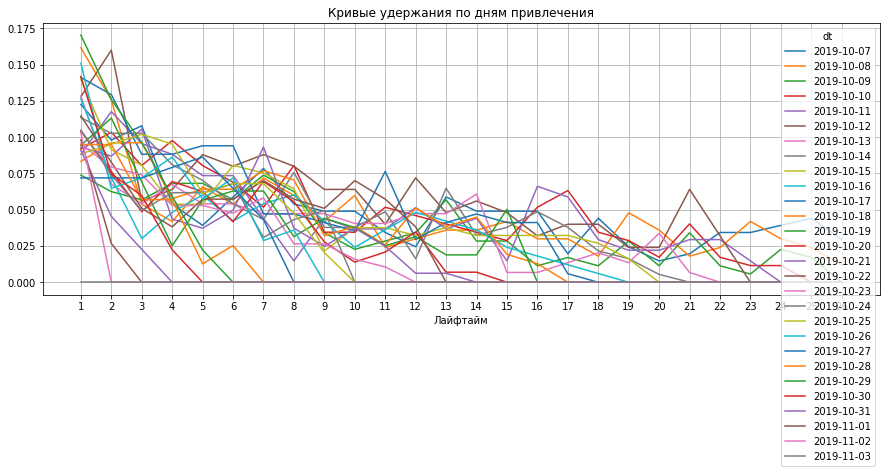

In [35]:
report = df_grouped.drop(columns = [0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

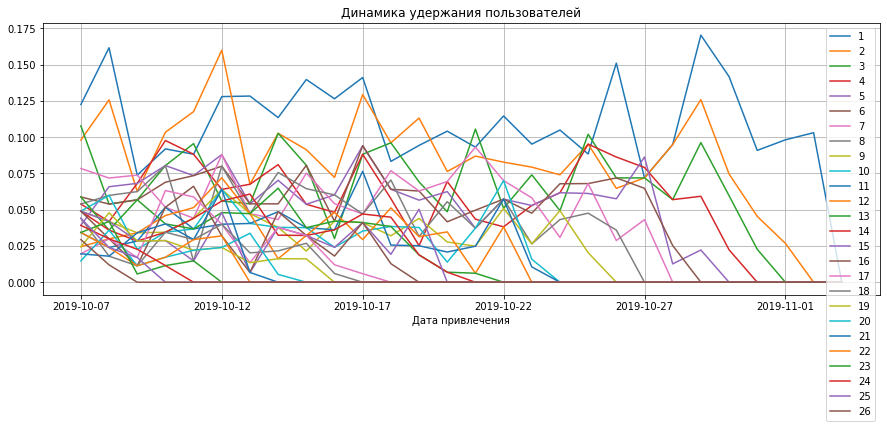

In [36]:
report = df_grouped.drop(columns = [0])

report.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()



Становится понятно, что ничего не понятно =//. 

Попробуем сократить число когорт с ежедневного до еженедельного

In [37]:
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     
3 2019-10-07 00:01:27.770232  advert_open   
4 2019-10-07 00:01:34.804591  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
3  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
4  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  lifetime  
0 2019-10-07 00:00:00.431357  2019-10-07  0         
1 2019-10-07 00:00:00.431357  2019-10-07  0         
2 2019-10-07 00:00:00.431357  2019-10-07  0         
3 2019-10-07 00:00:00.431357  2019-10-07  0         
4 2019-10-07 00:00:00.431357  2019-10-07  0

In [38]:
df['activity_week'] = df['time'].astype('datetime64[W]')
df['first_activity_week'] = df['first_ts'].astype('datetime64[W]')

In [39]:
df['week_lifetime'] = df['activity_week'] - df['first_activity_week']
df['week_lifetime'] = df['week_lifetime'] / np.timedelta64(1,'W')
df['week_lifetime'] = df['week_lifetime'].astype('int') 

In [40]:
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     
3 2019-10-07 00:01:27.770232  advert_open   
4 2019-10-07 00:01:34.804591  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
3  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
4  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  lifetime activity_week  \
0 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
1 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
2 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
3 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
4 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      

  first_activity_week  week_lifetime  
0 2019-10-03           0              
1 2019-10-03           0              
2 2019-10-03           0              
3 2019-10-03           0              
4 2019-10-03           0

In [41]:
# строим таблицу удержания

df1_grouped = df.pivot_table(
    index=['first_activity_week'], columns='week_lifetime', values='user_id', aggfunc='nunique'
)

df1_grouped

week_lifetime             0      1      2     3     4
first_activity_week                                  
2019-10-03           547.0   148.0  92.0   60.0  39.0
2019-10-10           1120.0  262.0  173.0  79.0 NaN  
2019-10-17           1136.0  273.0  101.0 NaN   NaN  
2019-10-24           1014.0  176.0 NaN    NaN   NaN  
2019-10-31           476.0  NaN    NaN    NaN   NaN

In [42]:
cohort1_sizes = (
    df.groupby('first_activity_week')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort1_sizes

cohort_size
first_activity_week             
2019-10-03           547        
2019-10-10           1120       
2019-10-17           1136       
2019-10-24           1014       
2019-10-31           476

In [43]:
# объединяем размеры когорт и таблицу удержания

df1_grouped = cohort1_sizes.merge(
    df1_grouped, on='first_activity_week', how='left'
).fillna(0)

df1_grouped

cohort_size       0      1      2     3     4
first_activity_week                                               
2019-10-03           547          547.0   148.0  92.0   60.0  39.0
2019-10-10           1120         1120.0  262.0  173.0  79.0  0.0 
2019-10-17           1136         1136.0  273.0  101.0  0.0   0.0 
2019-10-24           1014         1014.0  176.0  0.0    0.0   0.0 
2019-10-31           476          476.0   0.0    0.0    0.0   0.0

In [44]:
# делим данные таблицы удержания на размеры когорт

df1_grouped = df1_grouped.div(
    df1_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

df1_grouped

0         1         2         3         4
first_activity_week                                             
2019-10-03           1.0  0.270567  0.168190  0.109689  0.071298
2019-10-10           1.0  0.233929  0.154464  0.070536  0.000000
2019-10-17           1.0  0.240317  0.088908  0.000000  0.000000
2019-10-24           1.0  0.173570  0.000000  0.000000  0.000000
2019-10-31           1.0  0.000000  0.000000  0.000000  0.000000

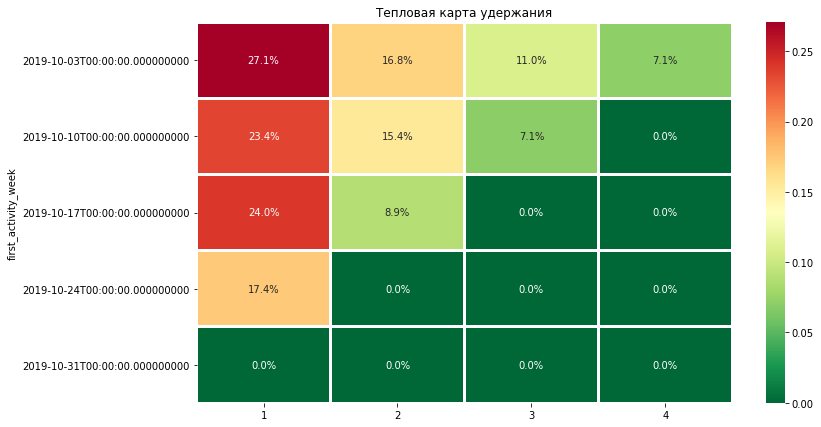

In [45]:
plt.figure(figsize=(12, 7))  # задаём размер графика
sns.heatmap(
    df1_grouped.drop(columns=0),  # удаляем размеры когорт
    cmap='RdYlGn_r', linewidths=1.5,
    annot=True,  # включаем подписи
    fmt='.1%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

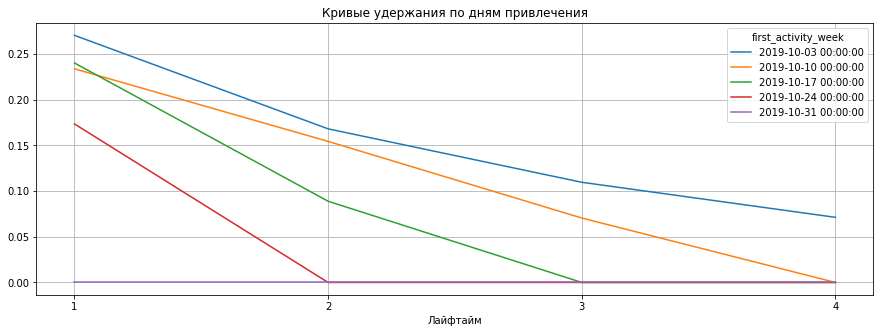

In [46]:
report1 = df1_grouped.drop(columns = [0])

report1.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report1.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

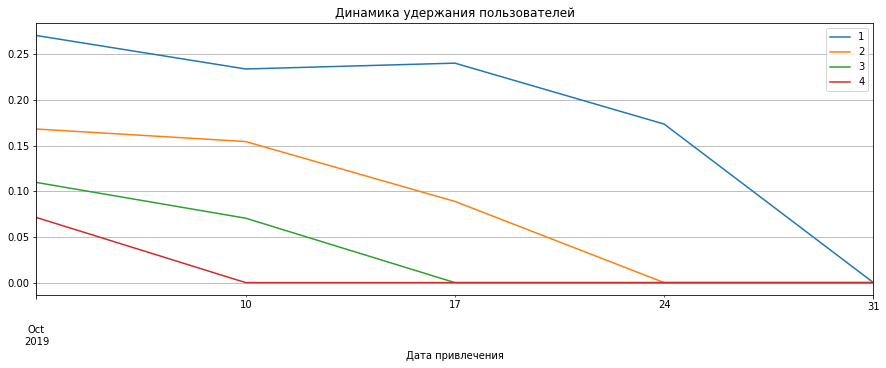

In [47]:
report1 = df1_grouped.drop(columns = [0])

report1.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()



Таким образом, **удержание  с течением времени** по еженедельным когортам **в первую неделю убывает**. Если для когорты юзеров, которые пришли с 7 октября по 13 октября, ретеншн в первую неделю составляет 27,1%, то для тех, кто пришел в четвертую неделю — уже 17,4 %. Так, за 3 недели коэффициент удержания упал почти на 10%. Можем судить о том, что с каждой новой когортой поведение пользователей меняется. Так же чем больше когорта проводит времени в приложении, тем больше отток. 

С другой стороны, **говорить о падении удержания вероятно скоропостижно**, может иметь место погрешность, слишком **маленький промежуток времени** прошел. 

<a id='part32'></a>
### Время в приложении

[*Назад к оглавлению*](#content)

In [48]:
df['date_time'] = df['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df.head()

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     
3 2019-10-07 00:01:27.770232  advert_open   
4 2019-10-07 00:01:34.804591  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
3  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
4  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  lifetime activity_week  \
0 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
1 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
2 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
3 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
4 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      

  first_activity_week  week_lifetime           date_time  
0 2019-10-03           0             2019-10-07 00:00:00  
1 2019-10-03           0             2019-10-07 00:00:01  
2 2019-10-03           0             2019-10-07 00:00:07  
3 2019-10-03           0             2019-10-07 00:01:27  
4 2019-10-03           0             2019-10-07 00:01:34




Пользовательские сессии `session_id	` мы уже выделили в предыдущем пункте.
Для расчета метрики данного пункта нам надо высчитать время между событиями каждого юзера.
Заведем столбец `previous_event_time`, который будет содержать в себе время предыдущего действия опять же для каждого юзера, и  столбец `session_time`, в котором будет содержаться количество времени, проведенное в приложении между действиями.

In [49]:
df['previous_event_time'] = df.groupby('user_id')['date_time'].shift()
df['session_time'] = df['date_time'] - df['previous_event_time']
df.head(3)

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  lifetime activity_week  \
0 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
1 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
2 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      

  first_activity_week  week_lifetime           date_time previous_event_time  \
0 2019-10-03           0             2019-10-07 00:00:00 NaT                   
1 2019-10-03           0             2019-10-07 00:00:01 2019-10-07 00:00:00   
2 2019-10-03           0             2019-10-07 00:00:07 2019-10-07 00:00:01   

     session_time  
0 NaT              
1 0 days 00:00:01  
2 0 days 00:00:06

In [50]:
#фильтруем столбец session_time следующим образом - если промежуток между действиями больше 30 минут - заменяем его на NaN
df['session_time'].loc[(df['session_time'] > pd.Timedelta(30,'m'))] = np.nan
df['session_time'].isnull().sum()

10368

In [51]:
#NaNы заменим на 0,чтобы при суммировании не возникло проблем
df['session_time'].fillna('0',inplace=True)

Построим сводную таблицу `session_grouped`, где сгруппируем данные по пользователям и номеру сессии и просуммируем время, проведенное в приложении

In [52]:
session_grouped = df.pivot_table(index = ['user_id','session_id'], values ='session_time', aggfunc ='sum').reset_index()
session_grouped

user_id  session_id    session_time
0      0001b1d5-b74a-4cbf-aeb0-7df5947bf349  101        0 days 00:09:56
1      0001b1d5-b74a-4cbf-aeb0-7df5947bf349  1449       0 days 00:08:27
2      0001b1d5-b74a-4cbf-aeb0-7df5947bf349  11577      0 days 00:01:08
3      0001b1d5-b74a-4cbf-aeb0-7df5947bf349  11584      0 days 00:08:14
4      0001b1d5-b74a-4cbf-aeb0-7df5947bf349  11603      0 days 00:05:38
...                                     ...    ...                  ...
26834  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  26162      0 days 00:01:14
26835  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  26187      0 days 00:12:18
26836  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  26199      0 days 00:01:22
26837  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  26204      0 days 00:00:34
26838  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  26248      0 days 00:16:28

[26839 rows x 3 columns]

Посмотрим на среднее и медианные значения времени, проведенного в приложении, а также среднее количество сессий пользователя за почти 28 дней

In [53]:
print('Среднее значение времени в приложении {} , а медианное {}.'.format(session_grouped['session_time'].mean(), session_grouped['session_time'].median()))

Среднее значение времени в приложении 0 days 00:04:58.486269980 , а медианное 0 days 00:02:58.


**Среднее** значение времени в приложении составляет **~5 минут, а медианное ~3 минуты**.

In [54]:
session_grouped.groupby('user_id')['session_id'].count().mean()

6.251805264383881



Таким образом, видим, что **пользователь** за исследуемый период времени **проводит в приложении** ориентировочно **6 сессий от 3 до 5 минут** каждая. 

В нашем случае это положительный аспект - *чем быстрее пользователь находит то, что ему нужно, тем лучше, ему удобно пользование и тем выше вероятность его повторного использования приложения*. 

Скорее всего следует развить направление привлечения новых пользователей.

<a id='part33'></a>
### Распределение событий по дням

[*Назад к оглавлению*](#content)

In [55]:
events = df.groupby(['dt','event']).agg({'date_time':'count'}).reset_index()
events.columns = ['date', 'event', 'cnt']
events
#events
cumsum_events = events.groupby('date').agg({'cnt':'sum'})['cnt'].reset_index()
cumsum_events.columns = ['date', 'cumsum']
#count_sum
events = events.merge(cumsum_events, on='date', how='left')
events.head(44)

date          event   cnt  cumsum
0   2019-10-07  advert_open    589   5667  
1   2019-10-07  contacts_call  20    5667  
2   2019-10-07  contacts_show  422   5667  
3   2019-10-07  favorites_add  87    5667  
4   2019-10-07  map            393   5667  
5   2019-10-07  photos_show    377   5667  
6   2019-10-07  search         251   5667  
7   2019-10-07  tips_click     95    5667  
8   2019-10-07  tips_show      3433  5667  
9   2019-10-08  advert_open    263   3682  
10  2019-10-08  contacts_call  23    3682  
11  2019-10-08  contacts_show  271   3682  
12  2019-10-08  favorites_add  109   3682  
13  2019-10-08  map            309   3682  
14  2019-10-08  photos_show    461   3682  
15  2019-10-08  search         411   3682  
16  2019-10-08  tips_click     34    3682  
17  2019-10-08  tips_show      1801  3682  
18  2019-10-09  advert_open    203   2783  
19  2019-10-09  contacts_call  22    2783  
20  2019-10-09  contacts_show  151   2783  
21  2019-10-09  favorites_add  80    2783  
22  2019-10-09  map            158   2783  
23  2019-10-09  photos_show    427   2783  
24  2019-10-09  search         293   2783  
25  2019-10-09  tips_click     21    2783  
26  2019-10-09  tips_show      1428  2783  
27  2019-10-10  advert_open    233   3781  
28  2019-10-10  contacts_call  22    3781  
29  2019-10-10  contacts_show  240   3781  
30  2019-10-10  favorites_add  47    3781  
31  2019-10-10  map            211   3781  
32  2019-10-10  photos_show    499   3781  
33  2019-10-10  search         316   3781  
34  2019-10-10  tips_click     32    3781  
35  2019-10-10  tips_show      2181  3781  
36  2019-10-11  advert_open    172   2795  
37  2019-10-11  contacts_call  16    2795  
38  2019-10-11  contacts_show  160   2795  
39  2019-10-11  favorites_add  28    2795  
40  2019-10-11  map            145   2795  
41  2019-10-11  photos_show    585   2795  
42  2019-10-11  search         266   2795  
43  2019-10-11  tips_click     26    2795

In [56]:
fig = px.bar(events, 
             x='date', 
             y='cnt', 
             color='event', 
             title="Распределение событий (в т.ч. пользователь увидел рекомендованные объявления)")
fig.show()

Рекомендации смазывают картину, посмотрим на распределение событий без них

In [57]:
fig = px.bar(events.query('event !="tips_show"'), 
             x='date', 
             y='cnt', 
             color='event',
             title="Распределение событий (без просмотра рекомендованных объявлений)")
fig.show()



1. Сразу очевидно, что очень **много событий**, связанных **с рекомендациями, но мало переходов** по ним, очень **низкая конверсия**.
2. Из этого вытекает взаимосвязь того, что **пользователи предпочитают пользоваться самостоятельным поиском**.
3. **Просмотр фотографий** в объявлении является **одним из самых популярных действий**, все пользователи хотят знать, что они собираются купить (21.10 наблюдается резкое сокращение просмотра фотографий более, чем в 2 раза, на следующий день так же резко возрастает до 27.10, потом идет на снижение). Динамика зависит от количества пришедших пользователей.
4. **Открытие карточки объявления** с первого дня исследования резко снизилось в динамике (с 589 до 263).
5. Максимальное число **добавления объявления в избранное** достигает 109 
6. Пользователи очень **активно достигают целевого события** `contacts_show`, можем сделать вывод, что люди действительно заинтересованы и **наше приложение полезно**
7. Совсем мало тех, кто звонит через приложение. Больше связано с тем, что люди **привыкли** делать, как им удобно - **записать номер и позвонить со своего телефона**.


<a id='part34'></a>
### Количество событий по пользователям

[*Назад к оглавлению*](#content)

Будем рассматривать данные без учета автоматического события рекомендаций

In [58]:
#вспомним наш сводник
user_events = df.pivot_table(index='user_id', values='event',aggfunc='count')
user_events.describe()

event
count  4293.000000
mean   17.283252  
std    29.130677  
min    1.000000   
25%    5.000000   
50%    9.000000   
75%    17.000000  
max    478.000000

In [59]:
#удалим из него рекомендации
user_events_query = df.query('event!="tips_show"').pivot_table(index='user_id', values='event',aggfunc='count')
user_events_query.describe()

event
count  3586.000000
mean   9.520915   
std    16.318064  
min    1.000000   
25%    3.000000   
50%    5.000000   
75%    10.000000  
max    336.000000

In [60]:
user_events_query.sort_values(by='event', ascending=False).reset_index().head()

user_id  event
0  e13f9f32-7ae3-4204-8d60-898db040bcfc  336  
1  9ce63488-758a-481a-bcb5-a02b467e1d84  225  
2  be1449f6-ca45-4f94-93a7-ea4b079b8f0f  180  
3  e38cb669-7335-4d56-9de5-c8d5d2f13fd3  167  
4  320cab3c-e823-4dff-8c01-c4253764640a  162

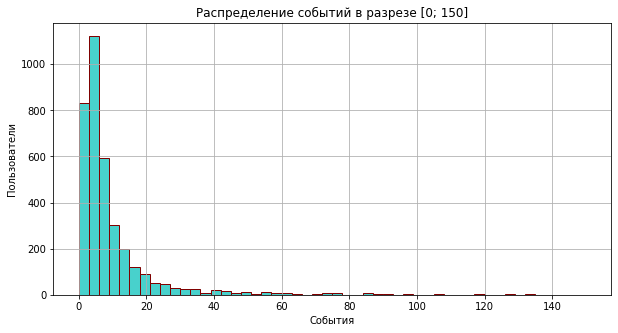

In [61]:
user_events_query['event'].hist(figsize=(10,5), 
                                color = 'mediumturquoise', 
                                edgecolor='maroon', 
                                bins=50,
                               range=(0,150))
plt.xlabel('События')
plt.ylabel('Пользователи')
plt.title('Распределение событий в разрезе [0; 150]')
plt.show()

In [62]:
 print('5% пользователей сделали больше {} событий' .format(user_events_query['event'].quantile(0.95)))

5% пользователей сделали больше 32.0 событий




Таким образом, видим следуюшее:

1. Из графика видно, что **основная масса** юзеров совершает **до 20 событий**.
2. **Среднее** количество событий на пользователя **9,5**, **медианное - 5**, так как имеются **выбросы до 336** событий на очень активного пользователя
3. **Четверть** пользователей совершают **до 10 событий**
4. **5%** пользователей сделали **больше 32.0 событий**

<a id='part35'></a>
### Конверсия в целевое действие (пользователи, пользующиеся самостоятельным поиском)

[*Назад к оглавлению*](#content)

Сравним конверсию воронки взаимодействия пользователей, для этого исключим юзеров, которые взаимодействовали с `tips_click`, оставим `search`, `contacts_show`, `contacts_call`, `advert_open`, `favorites_add`


In [63]:
tips_click = df.query('event == "tips_click"')
tips_click_users_list = tips_click['user_id'].unique().tolist() #уникальные пользователи, которые пользовались реками

search = df.query('event == "search"')
search_users_list = search['user_id'].unique().tolist() #уникальные пользователи, которые пользовались поиском

In [64]:
search_funnel = df.query('user_id not in @tips_click_users_list') # выбираем пользователей, не пользовавшихся реками
search_funnel = search_funnel.query('user_id in @search_users_list') # воронка  с уникальными юзерами, которые пользовались поиском

предположим, что пользователь идет по воронке следующим образом: 

ищет объявление (без просмотра карты) / открывает карточку / смотрит фотографии / смотрит контакты (достигает целевого)

In [65]:
search_funnel =  search_funnel.query('event == "search" or event == "advert_open" or event == "photos_show" or event == "contacts_show"  ')


In [66]:
search_users_count = search_funnel.groupby('event').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

search_funnel_name = search_funnel['event'].value_counts().to_frame().reset_index()['index'].to_list()
#search_users_count 
search_funnel_count = search_users_count['user_id'].to_frame().reset_index()['user_id'].to_list()
#search_funnel_count

Строим воронку

In [67]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y = search_funnel_name,
    x = search_funnel_count,
    opacity = 0.65, 
    marker = {"color": ["deepskyblue", "lightsalmon", "teal", "orange"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "wheat", "blue"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}},
    textinfo = "value+percent initial+percent previous"))

fig.update_layout(title='Воронка взаимодействий юзеров, пользующихся самостоятельным поиском')
fig.show()



Имеем следующее:

1. *После поиска по сайту* **41%** пользователей **сначала ознакомительно смотрят фотографии (644 из 1565)**
2. *После просмотра фотографий*  **54%**  **открывают карточку объявления**, чтобы детально ознакомиться с объявлением (**22% от общего** числа юзеров)
3. *После открытия карточки* объявления **88%** пользователей **достигает целевого действия** (**19% от общего** количества пользователей)


<a id='part36'></a>
### Конверсия в целевое действие (пользователи, пользующиеся рекомендациями)

[*Назад к оглавлению*](#content)

Идем аналогичным предыдущему шагу путем, отследим конверсию в целевое событие

In [68]:
tips_click_funnel = df.query('user_id not in @search_users_list')
tips_click_funnel = tips_click_funnel.query('user_id in @tips_click_users_list')

tips_click_funnel = tips_click_funnel.query('event =="tips_click"  or event == "contacts_show"  or event =="tips_show"')

In [69]:
tips_click_users_count = tips_click_funnel.groupby('event').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
#tips_click_users_count

In [70]:
tips_click_funnel_count = tips_click_users_count['user_id'].to_frame().reset_index()['user_id'].to_list()

tips_click_funnel_name = tips_click_funnel['event'].value_counts().to_frame().reset_index()['index'].to_list()
#tips_click_funnel_count

In [71]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    y = tips_click_funnel_name,
    x = tips_click_funnel_count,
    opacity = 0.65, 
    marker = {"color": ["deepskyblue", "lightsalmon", "orange", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}},
    textinfo = "value+percent initial+percent previous"))

fig.update_layout(title='Воронка взаимодействий юзеров, пользующихся системой рекомендаций')
fig.show()



Имеем следующее:

1. **93%** пользователей, взаимодействовавших **с `tips_show` перешли на `tips_click`**

3. **До целевого действия `contacts_show`** дошли **31%** от тех, **кто перешел на рекомендованное объявление**, и **29%* от общего количества юзеров, **увидевших рекомендацию**.




Таким образом, можем заключить следующее:

ПОИСК:

- **Пользователи** гораздо более **подвержены использованию самостоятельного поиска**, среди них **19% доходит до целевого действия**


РЕКОМЕНДАЦИИ:

- **На рекомендованные** объявления обращает внимание малое количество пользователей и зря - ведь из тех, кто воспользовался рекомендацией,  **29 % доходят до целевого действия**. Отсюда можно сделать вывод, что **система рекомендаций выстроена верно** (возможно, людей пугает такое количество рекомендаций и они заранее предвзяты)


*Рекомендации являются  одним из основных инструментов влияния на пользователя*


<a id='part4'></a>
## Сегментация пользователей

[*Назад к оглавлению*](#content)

Предлагаю ***сегментировать пользователей по их действиям** в приложении, а именно:

1. *по источнику*, с которого пользователь установил приложение (действие `source`) 
2. по пользователям, *позвонившим по номеру телефона* на карточке объявления (действие `contacts_call`)
3. по пользователям, которые *пользовались поиском* (действие `search`) 
4. по пользователям, *кликнувшим по рекомендованным* объявлениям (действие `tips_click`) 
5. по пользователям, *открывшим карточки* объявления (действие `advert_open`) 
6. по пользователям, *просмотревшим рекомендации* (действие `tips_show`) 
7. по пользователям, *открывшим карту* размещенных объявлений (действие `map`) 

Настолько подробная сегментация даст нам представления о действиях пользователей в разрезе каждого из значимых действий в приложении, мы поймем сколько времени и какое количество сессий придется на каждый этап, сможем в дальнейшем оптимизировать работу приложения, поймем, где люди дольше удерживаются и рассмотрим варианты рекомендаций для оптимизации.

Для этого нужно датасет отфильтровать по действиям и найти уникальных юзеров, которые эти действия совершили. Далее фильтранем основной датасет по этим юзерам, и увидим, как они себя в этих группах вели и какая часть из них дошла до целевого `contacts_show`.

<a id='part41'></a>
### Расчет метрик для сегментированных групп

[*Назад к оглавлению*](#content)

Напишем две функции, которые помогут нам анализировать наши группы:
- функция расчета удержания (будет считать ретеншн и строить хитмэп)
- функция расчета метрик (количество уникальных юзеров, их долю от общего числа, частоту совершаемых событий, среднее время в приложении, среднее количество сессий, конверсию в целевое действие)

In [72]:
def retention(dataset):
    
    cohorts = dataset.groupby(['first_activity_week','week_lifetime']).agg({'user_id':'nunique'}).reset_index() 
    start_users_cnt = cohorts[cohorts['week_lifetime'] == 0][['first_activity_week','user_id']]
    start_users_cnt = start_users_cnt.rename(columns={'user_id':'cohort_users'}) 

    cohorts = cohorts.merge(start_users_cnt,on='first_activity_week')
    cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

    retention_pivot = cohorts.pivot_table(index='first_activity_week',columns='week_lifetime',values='retention',aggfunc='sum') 
    retention_pivot.index = retention_pivot.index.strftime("%w")
    
    
    plt.figure(figsize=(10, 5))
    plt.title('Удержание по когортам')
    sns.heatmap(retention_pivot, 
                annot=True, 
                fmt='.2f', 
                cmap='RdYlGn_r',
                linewidths=1, 
                linecolor='grey')
    plt.gca().set(xlabel='лайфтайм', ylabel='1 неделя активности')
    plt.show()

In [73]:
def metrics_of_segment(dataset):
    unique_users = dataset['user_id'].nunique()
    print('Количество уникальных пользователей в группе равно')
    print(unique_users)
    print('')
    
    ratio_users = (dataset['user_id'].nunique() / df['user_id'].nunique()) * 100
    print('Доля пользователей в группе от их общего числа равна')
    print('{:.2f}'.format(ratio_users))
    print('')
    
    print('Среднее число действий пользователя в группе равно')
    users_events = dataset.groupby('user_id').agg({'event':'count'})
    mean_events = users_events['event'].mean()
    print('{:.2f}'.format(mean_events))
    print('')
    
    session_grouped = dataset.pivot_table(index = ['user_id','session_id'], 
                                        values ='session_time', 
                                        aggfunc ='sum').reset_index()
    median_time = session_grouped['session_time'].median()
    print('Медианное время, проведенное пользователями в приложении равно')
    print(median_time)
    print('')
    
    mean_time = session_grouped['session_time'].mean()
    print('Среднее время, проведенное пользователями в приложении равно')
    print(mean_time)
    print('')
    
    mean_sessions = session_grouped.groupby('user_id')['session_id'].count().mean()
    print('Среднее число сессий пользователя в группе равно')
    print('{:.2f}'.format(mean_sessions))
    print('')
    
    print('Конверсия в целевое действие по группе равна')
    contacts_show = dataset.query('event == "contacts_show"')
    conversion = (contacts_show['user_id'].nunique() / dataset['user_id'].nunique()) * 100
    print('{:.2f}'.format(conversion))
    print('')

<a id='part42'></a>
### Расчет метрик по источнику, с которого пользователь установил приложение

[*Назад к оглавлению*](#content)

In [74]:
df['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [75]:
yandex = df.query('source == "yandex"')
google = df.query('source == "google"')
other = df.query('source == "other"')

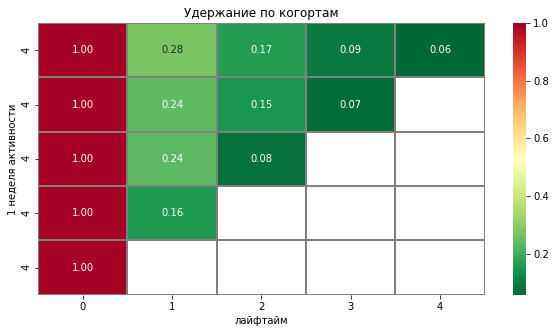

Количество уникальных пользователей в группе равно
1934

Доля пользователей в группе от их общего числа равна
45.05

Среднее число действий пользователя в группе равно
17.73

Медианное время, проведенное пользователями в приложении равно
0 days 00:03:11

Среднее время, проведенное пользователями в приложении равно
0 days 00:05:10.278699186

Среднее число сессий пользователя в группе равно
6.36

Конверсия в целевое действие по группе равна
24.72



In [76]:
retention(yandex)
metrics_of_segment(yandex)

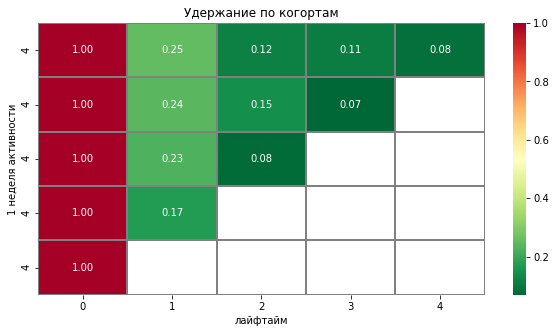

Количество уникальных пользователей в группе равно
1129

Доля пользователей в группе от их общего числа равна
26.30

Среднее число действий пользователя в группе равно
18.11

Медианное время, проведенное пользователями в приложении равно
0 days 00:02:55

Среднее время, проведенное пользователями в приложении равно
0 days 00:04:57.149365397

Среднее число сессий пользователя в группе равно
6.63

Конверсия в целевое действие по группе равна
24.36



In [77]:
retention(google)
metrics_of_segment(google)

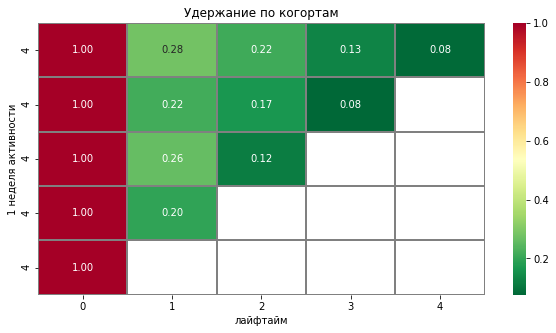

Количество уникальных пользователей в группе равно
1230

Доля пользователей в группе от их общего числа равна
28.65

Среднее число действий пользователя в группе равно
15.83

Медианное время, проведенное пользователями в приложении равно
0 days 00:02:37

Среднее время, проведенное пользователями в приложении равно
0 days 00:04:39.342500708

Среднее число сессий пользователя в группе равно
5.73

Конверсия в целевое действие по группе равна
18.54



In [78]:
retention(other)
metrics_of_segment(other)



По показателям в разрезе источников:
- **больше** пользователей, **установивших приложение** с помощью **Яндекс**. 
- **конверсия в целевое** действие **у групп Яндеск и Google** практически **равны ~24%**, у **других** источников **18,5%**
- **коэффициент удержания** *во всех группах примерно одинаковый* - к последней неделе он достаточно низкий у всех, однако в группе Яндекса на 2% меньше, немного меньше пользователей, установивших приложение через Яндекс, остается с нами.
- **Среднее время**, проведенное в приложении: **яндекс - 05:10, гугл - 04:57, другие источники - 04:39**

<a id='part43'></a>
### Расчет метрик по пользователям, позвонившим по номеру телефона на карточке объявления

[*Назад к оглавлению*](#content)

In [79]:
contacts_call = df.query('event == "contacts_call"')
contacts_call_users = contacts_call['user_id'].unique()
contacts_call_full = df[df['user_id'].isin(contacts_call_users)]

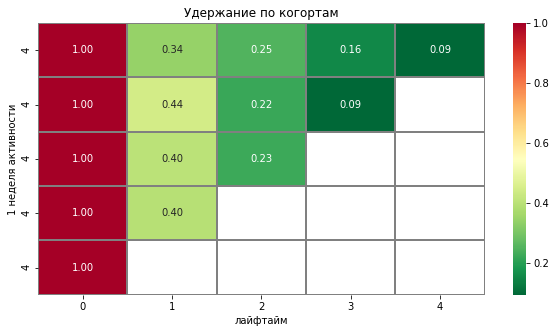

Количество уникальных пользователей в группе равно
213

Доля пользователей в группе от их общего числа равна
4.96

Среднее число действий пользователя в группе равно
19.12

Медианное время, проведенное пользователями в приложении равно
0 days 00:02:04

Среднее время, проведенное пользователями в приложении равно
0 days 00:04:21.643315820

Среднее число сессий пользователя в группе равно
8.04

Конверсия в целевое действие по группе равна
100.00



In [80]:
retention(contacts_call_full)
metrics_of_segment(contacts_call_full)



По показателям в разрезе "позвонивших по номеру телефона" юзеров:

- группа малочисленная (**213 пользователей**)
- они проводят достаточно много времени в приложении - в среднем **8 сессий**
- медиана проведенного **в приложении времени около 2 минут**. 
- В среднем пользователь совершает **20 действий** в приложении. 
- **конверсия в целевое действие** составляет **23,6%** . 
- **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **12%**, эти пользователи более стабильны, чем в других группах
- **среднее время**, проведенное в приложении - **04:21**

<a id='part44'></a>
### Расчет метрик по пользователям, использующим поиск

[*Назад к оглавлению*](#content)

In [81]:
search = df.query('event == "search"')
search_users = search['user_id'].unique()
search_full = df[df['user_id'].isin(search_users)]

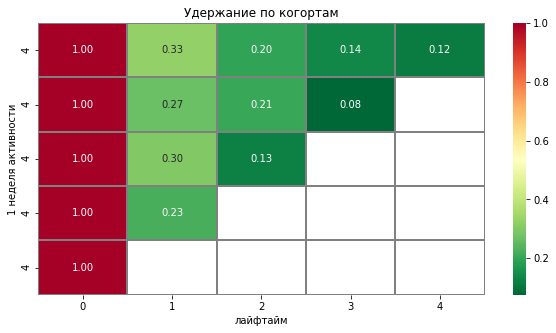

Количество уникальных пользователей в группе равно
1666

Доля пользователей в группе от их общего числа равна
38.81

Среднее число действий пользователя в группе равно
20.18

Медианное время, проведенное пользователями в приложении равно
0 days 00:02:52

Среднее время, проведенное пользователями в приложении равно
0 days 00:05:00.052122885

Среднее число сессий пользователя в группе равно
6.96

Конверсия в целевое действие по группе равна
22.63



In [82]:
retention(search_full)
metrics_of_segment(search_full)



По показателям в разрезе "поисковых" юзеров:

- группа достаточно крупная (**1666 пользователей**)
- они проводят достаточно много времени в приложении - в среднем **7 сессий**
- медиана проведенного **в приложении времени около 2 минут**. 
- В среднем пользователь совершает **20 действий** в приложении. 
- **конверсия в целевое действие** составляет **23,6%** . 
- **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **12%**, эти пользователи более стабильны, чем в других группах
- **среднее время**, проведенное в приложении - **05:00**

<a id='part45'></a>
### Расчет метрик по пользователям, кликнувшим по рекомендованным объявлениям

[*Назад к оглавлению*](#content)

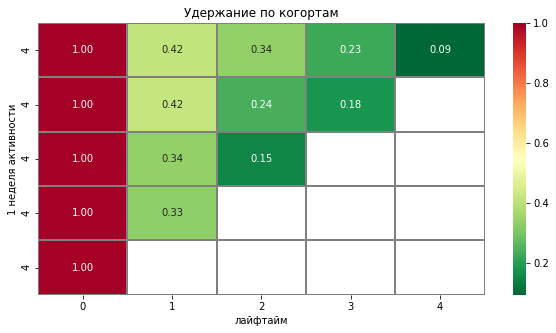

Количество уникальных пользователей в группе равно
322

Доля пользователей в группе от их общего числа равна
7.50

Среднее число действий пользователя в группе равно
39.00

Медианное время, проведенное пользователями в приложении равно
0 days 00:03:31

Среднее время, проведенное пользователями в приложении равно
0 days 00:05:41.110212114

Среднее число сессий пользователя в группе равно
14.20

Конверсия в целевое действие по группе равна
31.06



In [83]:
tips_click = df.query('event == "tips_click"')
tips_click_users = tips_click['user_id'].unique()
tips_click_full = df[df['user_id'].isin(tips_click_users)]

retention(tips_click_full)
metrics_of_segment(tips_click_full)




По показателям в разрезе кликнувшим по рекомендованным объявлениям юзеров:

- группа маленькая (**322 пользователей**)
- они проводят очень много времени в приложении - в среднем **14 сессий**
- медиана проведенного **в приложении времени около 3 минуты**. 
- В среднем пользователь совершает **39 действий** в приложении. 
- **конверсия в целевое действие** составляет **31%** . 
- **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **9%**, что неплохо
- **среднее время**, проведенное в приложении - **05:41**

<a id='part46'></a>
### Расчет метрик по пользователям, открывшим карточки объявления

[*Назад к оглавлению*](#content)

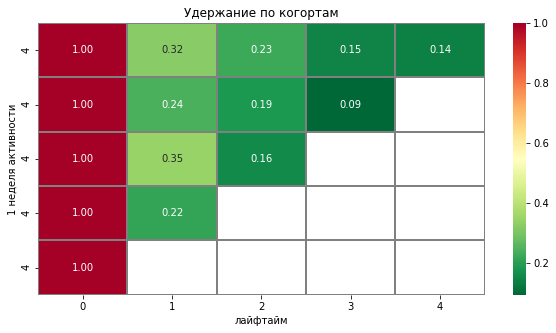

Количество уникальных пользователей в группе равно
751

Доля пользователей в группе от их общего числа равна
17.49

Среднее число действий пользователя в группе равно
31.74

Медианное время, проведенное пользователями в приложении равно
0 days 00:03:12

Среднее время, проведенное пользователями в приложении равно
0 days 00:05:23.765481651

Среднее число сессий пользователя в группе равно
9.29

Конверсия в целевое действие по группе равна
18.38



In [84]:
advert_open = df.query('event == "advert_open"')
advert_open_users = advert_open['user_id'].unique()
advert_open_full = df[df['user_id'].isin(advert_open_users)]

retention(advert_open_full)
metrics_of_segment(advert_open_full)



По показателям в разрезе открывших карточки объявления юзеров:

- группа небольшая (**751 пользователей**)
- они проводят достаточно времени в приложении - в среднем **9 сессий**
- медиана проведенного **в приложении времени около 3 минуты**. 
- В среднем пользователь совершает **32 действий** в приложении. 
- **конверсия в целевое действие** составляет **18,4%** . 
- **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **14%** , очень стабильные пользователи
- **среднее время**, проведенное в приложении - **05:23**

<a id='part47'></a>
### Расчет метрик по пользователям, просмотревшим рекомендации

[*Назад к оглавлению*](#content)

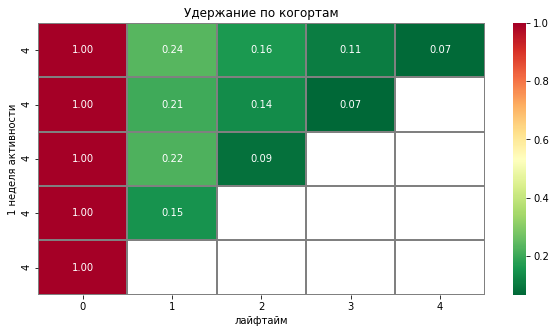

Количество уникальных пользователей в группе равно
2801

Доля пользователей в группе от их общего числа равна
65.25

Среднее число действий пользователя в группе равно
20.11

Медианное время, проведенное пользователями в приложении равно
0 days 00:03:14

Среднее время, проведенное пользователями в приложении равно
0 days 00:05:12.303886925

Среднее число сессий пользователя в группе равно
6.87

Конверсия в целевое действие по группе равна
18.42



In [85]:
tips_show = df.query('event == "tips_show"')
tips_show_users = tips_show['user_id'].unique()
tips_show_full = df[df['user_id'].isin(tips_show_users)]

retention(tips_show_full)
metrics_of_segment(tips_show_full)


    
По показателям в разрезе открывших карточки объявления юзеров:

- сама большая группа (**2801 пользователей, 65% от общего**)
- они проводят достаточно времени в приложении - в среднем **7 сессий**
- медиана проведенного **в приложении времени около 3 минуты**. 
- В среднем пользователь совершает **20 действий** в приложении. 
- **конверсия в целевое действие** составляет **18,4%** . 
- **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **7%** - пользователи нестабильны
- **среднее время**, проведенное в приложении - **05:12**

Можем подтвердить свою догадку, что пользователи "зависают" на этом шаге

<a id='part48'></a>
### Расчет метрик по пользователям, открывшим карту размещенных объявлений

[*Назад к оглавлению*](#content)

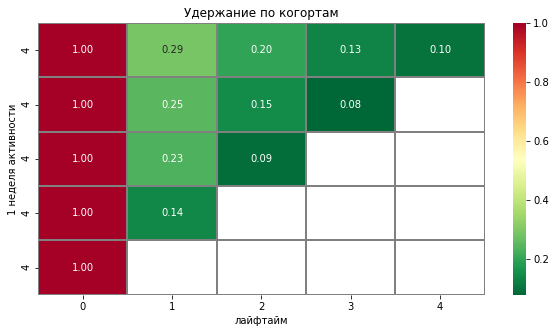

Количество уникальных пользователей в группе равно
1456

Доля пользователей в группе от их общего числа равна
33.92

Среднее число действий пользователя в группе равно
25.94

Медианное время, проведенное пользователями в приложении равно
0 days 00:03:21

Среднее время, проведенное пользователями в приложении равно
0 days 00:05:23.462503114

Среднее число сессий пользователя в группе равно
8.27

Конверсия в целевое действие по группе равна
19.85



In [86]:
map = df.query('event == "map"')
map_users = map['user_id'].unique()
map_full = df[df['user_id'].isin(map_users)]

retention(map_full)
metrics_of_segment(map_full)



По показателям в разрезе открывших карту юзеров:

- одна из самых больших группа (**1456 пользователей, 34% от общего**)
- они проводят достаточно времени в приложении - в среднем **8 сессий**
- медиана проведенного **в приложении времени около 3 минуты**. 
- В среднем пользователь совершает **26 действий** в приложении. 
- **конверсия в целевое действие** составляет **19,9%** . 
- **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **10%** - нормальный показатель
- **среднее время**, проведенное в приложении - **05:23**


<a id='part49'></a>
### Выводы

[*Назад к оглавлению*](#content)



Пользователи приложения были сегментированы по семи признакам. Мы рассчитали метрики и проанализировали их поведение по расчитанным выше метрикам рассмотрели их поведение.
   
    
1. **Retention Rate** - одни из самых стабильных групп - группы, открывающие карточку объявлений, пользующиеся самостоятельным поиском и изучающие карты
    
    группа source: **яндекс - 28-6%, гугл - 25-8% , другие - 28-8%**
    
    группа contacts_call: **34-9 %%**
    
    группа search: **33-12 %%**
    
    группа tips_click: **42-9 %%**
    
    группа advert_open: **32-14 %%**
    
    группа tips_show: **24-7 %%**
    
    группа map: **29-10 %%**
    
2. **Конверсия в целевое действие** - конвертируются лучше остальных в целевое люди, кликающие на рекомендованные объявления, и установившие прилоежения с помощью яндекс или гугл, а также пользующиеся самостоятельнам поиском
    
    группа source: яндекс - **24.72%, гугл - 24.36%, другие - 18.54 %**
    
    группа contacts_call: **100.00%**
    
    группа search: **22.63%**
    
    группа tips_click: **31.06%**
    
    группа advert_open: **18.38%**
    
    группа tips_show: **18.42%**
    
    группа map: **19.85%**
    
3. **Время в приложении (медиана/среднее)** - дольше всего находятся в приложении люди, кликающие на рекомендованные, открывшие карточку и изучающие карту
    
    группа source яндекс - 03:11/**05:10**, гугл -02:55/**04:57** , другие - 02:37/**04:39**
    
    группа contacts_call: 02:04/**04:21**
    
    группа search: 02:52/**05:00**
    
    группа tips_click: 03:31/**05:41**
    
    группа advert_open: 03:12/**05:23**
    
    группа tips_show: 03:14/**05:12**
    
    группа map: 03:21/**05:23**
    
    
 Таким образом, можно выделить несколько групп:
    
    - группа `map` - неплохое удержание и время в приложении, конверсия слабовата (можно предположить, что они долго ищут необходимое в удобном районе, но не находят)
    
    - группа `tips_click` - самая лучшая конверсия и время в приложении (все-таки наша гипотеза о том, что система рекомендаций выстроена верно, подтверждается - люди находят необходимое), однако доля оставшихся 9% - это ни много, ни мало для того чтобы судить в режиме ограниченного времени наблюдейний
    
    - группа `search` - хорошее удержание и конверсия в целевое, проводят в приложении чуть меньше времени, чем остальные (немного отработать систему поиска - и конверсия должна увеличиться)
    
    - группа `advert_open` показывает наибольшее удержание и время на сайте, однако самую низкую конверсию

Можно отметить следующее:

- нужно отладить систему привлечения большего количества пользователей с таких источников, как яндекс и google здесь достаточно неплохая конверсия в целевое действие в сравнении с другими группами

- группа, используящая поиск по приложению, довольно стабильна, однако следует поработать над упрощением этой функции - сама по себе группа не очень многочислена

- размещают объявления больше пользователей, чем просматривают чужие

<a id='part5'></a>
## Проверка гипотез

[*Назад к оглавлению*](#content)

<a id='part51'></a>
### Гипотеза 1

[*Назад к оглавлению*](#content)

Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. 

**Проверка гипотезы: две эти группы демонстрируют разную конверсию в просмотры контактов.**

Для проверки гипотезы мы проведем **z-test**. Создадим таблицу, в которой по действиям и источникам посчитаем уникальных пользователей

In [87]:
users_group_events = df.pivot_table(index='event', 
                                    values='user_id', 
                                    columns='source', 
                                    aggfunc=lambda x: x.nunique())
users_group_events

source         google  other  yandex
event                               
advert_open    195     259    297   
contacts_call  67      54     92    
contacts_show  275     228    478   
favorites_add  114     77     160   
map            354     415    687   
photos_show    363     289    443   
search         485     557    624   
tips_click     71      101    150   
tips_show      651     840    1310

Дропнем столбец с другими ресурсами

In [88]:
users_group_events= users_group_events.drop('other',1)

users_group_events

source         google  yandex
event                        
advert_open    195     297   
contacts_call  67      92    
contacts_show  275     478   
favorites_add  114     160   
map            354     687   
photos_show    363     443   
search         485     624   
tips_click     71      150   
tips_show      651     1310



***H0***: *Конверсии групп yandex и google в просмотр контактов равны с точки зрения равенства долей*

***H1***: *Конверсии групп yandex и google в просмотр контактов различаются с точки зрения равенства долей*.

In [89]:
# все пользователи
all_users = df.groupby('source').user_id.nunique()
all_users
#print(all_users.loc[all_users.index[0]]) 

source
google    1129
other     1230
yandex    1934
Name: user_id, dtype: int64

In [90]:
# конверсионные пользователи
conv_users = df[df.event=='contacts_show'].groupby('source').user_id.nunique()
conv_users
#print(conv_users.loc[conv_users.index[0]]) 

source
google    275
other     228
yandex    478
Name: user_id, dtype: int64

In [91]:
alpha = .05 # критический уровень статистической значимости
        
successes = np.array([conv_users.loc[conv_users.index[0]] , conv_users.loc[conv_users.index[2]]])
trials = np.array([all_users.loc[all_users.index[0]] , all_users.loc[all_users.index[2]]]) 
        
print("successes: ")
print(successes)

print("trials:")
print(trials)

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

successes: 
[275 478]
trials:
[1129 1934]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**Статистически значимой разницы в конверсии групп yandex и google нет**

<a id='part52'></a>
### Гипотеза 2

[*Назад к оглавлению*](#content)

***Среднее время, проведенное в приложении, у групп пользователей ,совершивших целевое действие(просмотр контактов) и не совершивших его, различается***


Отфильтруем таблицы по поьзователям, которые совершали и не совершали целевое действие. Преобразуем тип данных столбца session_time в integer для применения **t-test**-a.

In [92]:
df['session_time'] = df['session_time'].astype('timedelta64[m]')

In [93]:
contacts_show = df.query('event == "contacts_show"') 
contacts_show_users = contacts_show['user_id'].unique()
contacts_show_full = df[df['user_id'].isin(contacts_show_users)]

contacts_show_full['session_time'] = contacts_show_full['session_time'].astype('int')

In [94]:
contacts_show_full.head(3)

time          event  \
121 2019-10-07 00:02:07.374346  tips_show       
122 2019-10-07 00:05:16.003328  contacts_show   
123 2019-10-07 00:06:01.349291  tips_show       

                                  user_id  source  session_id  \
121  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex  3            
122  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex  3            
123  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex  3            

                      first_ts          dt  lifetime activity_week  \
121 2019-10-07 00:02:07.374346  2019-10-07  0        2019-10-03      
122 2019-10-07 00:02:07.374346  2019-10-07  0        2019-10-03      
123 2019-10-07 00:02:07.374346  2019-10-07  0        2019-10-03      

    first_activity_week  week_lifetime           date_time  \
121 2019-10-03           0             2019-10-07 00:02:07   
122 2019-10-03           0             2019-10-07 00:05:16   
123 2019-10-03           0             2019-10-07 00:06:01   

    previous_event_time  session_time  
121 NaT                  0             
122 2019-10-07 00:02:07  180000000000  
123 2019-10-07 00:05:16  0

In [95]:
contacts_show_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27197 entries, 121 to 74191
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 27197 non-null  datetime64[ns]
 1   event                27197 non-null  object        
 2   user_id              27197 non-null  object        
 3   source               27197 non-null  object        
 4   session_id           27197 non-null  int64         
 5   first_ts             27197 non-null  datetime64[ns]
 6   dt                   27197 non-null  object        
 7   lifetime             27197 non-null  int64         
 8   activity_week        27197 non-null  datetime64[ns]
 9   first_activity_week  27197 non-null  datetime64[ns]
 10  week_lifetime        27197 non-null  int64         
 11  date_time            27197 non-null  datetime64[ns]
 12  previous_event_time  26216 non-null  datetime64[ns]
 13  session_time         27197 no

In [96]:
no_contacts_show_full = df[~df['user_id'].isin(contacts_show_users)]
no_contacts_show_full['session_time'] = no_contacts_show_full['session_time'].astype('int')    
no_contacts_show_full.head(3)

time        event  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320  tips_show     
2 2019-10-07 00:00:07.039334  tips_show     

                                user_id source  session_id  \
0  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
1  020292ab-89bc-4156-9acf-68bc2783f894  other  1            
2  020292ab-89bc-4156-9acf-68bc2783f894  other  1            

                    first_ts          dt  lifetime activity_week  \
0 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
1 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      
2 2019-10-07 00:00:00.431357  2019-10-07  0        2019-10-03      

  first_activity_week  week_lifetime           date_time previous_event_time  \
0 2019-10-03           0             2019-10-07 00:00:00 NaT                   
1 2019-10-03           0             2019-10-07 00:00:01 2019-10-07 00:00:00   
2 2019-10-03           0             2019-10-07 00:00:07 2019-10-07 00:00:01   

   session_time  
0  0             
1  0             
2  0



***H0***: *Среднее время, проведенное в приложении, у групп пользователей ,совершивших целевое действие(просмотр контактов) и не совершивших его, равно*

***H1***: *Среднее время, проведенное в приложении, у групп пользователей ,совершивших целевое действие(просмотр контактов) и не совершивших его, различается*.

In [97]:
alpha = .05

results = st.ttest_ind(
    contacts_show_full['session_time'], 
    no_contacts_show_full['session_time'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.3708249887152037e-24
Отвергаем нулевую гипотезу




**Существует статистически значимое различие в среднем времени, проведенном в приложении, у групп пользователей, совершивших целевое действие(просмотр контактов) и не совершивших его**

<a id='part6'></a>
## Выводы и рекомендации

[*Назад к оглавлению*](#content)



**НА ЭТАПЕ ПРЕДОБРАБОТКИ И ИССЛЕДОВАНИЯ ДАННЫХ** в нашем распоряжении оказалось 2 датасета:
    
 `mobile_dataset` - **74197 строки, 3 столбца** - данные о идентификаторах пользователей, времени совершения событий и типе событий. 
    
 `mobile_sources` - **4293 строки, 2 столбца** - данные об идентификаторах пользователей и об источниках, с которых пользователи устанавливают приложение.

В обоих датасетах **отсутствуют пропуски и дубликаты**. Тип данных `event_time` заменили на *datetime*.

Тажк изменены названия столбцов и типы событий приведены к единообразию в части целевого события (*contacts_show*) и в части поиска (*search*).

Выявлено, что **идентификаторы пользователей уникальны в обоих датасетах**, соответствуют друг другу количественно и "качественно".

Определен временной промежуток, данными за который мы располагаем - **данные за период с 7.10.2019 по 3.11.2019**, всего у нас практически 28 дней, данные полные.

Оба датасета объеденены в один `df`, также проверен на дубликаты (отсутствуют).

Выяснили, что **в среднем на пользователя приходится 17 событий** (медианное значение 9). Из гистограмм видим, что выбросов много и они доходят до 478 событий на пользователя за 28 дней (кто-то очень активный), их удаление чревато потерей данных, можено сделать вывод, что данные похожи на правду.
    
**НА ЭТАПЕ АНАЛИЗА ДАННЫХ** ***были выделены пользовательские сессии*** и рассчитаны следующие метрики:

1. **Retantion Rate** - в рамках ***ежедневных когорт*** показатели небольшие, максимальное значение на второй день у когорты от 29 октября составляет 17%. Самые маленькие значения показателя у когорт от и 27 октября (7,4 и 7,2 %% соответственно) Если анализировать то, что получилось, становится ясно, что самый высокий коэффициент удержания у когорт от 08, 26 и 29 октября. В рамках ***еженедельных когорт*** **удержание  с течением времени** по еженедельным когортам **в первую неделю убывает**. Если для когорты юзеров, которые пришли с 7 октября по 13 октября, ретеншн в первую неделю составляет 27,1%, то для тех, кто пришел в четвертую неделю — уже 17,4 %. Так, за 3 недели коэффициент удержания упал почти на 10%. Можем судить о том, что с каждой новой когортой поведение пользователей меняется. Так же чем больше когорта проводит времени в приложении, тем больше отток. 

С другой стороны, **говорить о падении удержания вероятно скоропостижно**, может иметь место погрешность, слишком **маленький промежуток времени** прошел. 
    
2. **Время в приложении** - пользователь за исследуемый период времени **проводит в приложении** ориентировочно **6 сессий от 3 до 5 минут** каждая. 

В нашем случае это положительный аспект - *чем быстрее пользователь находит то, что ему нужно, тем лучше, ему удобно пользование и тем выше вероятность его повторного использования приложения*. 

Скорее всего следует развить направление привлечения новых пользователей.
    
3. **Распределение событий**:
    - Сразу очевидно, что очень **много событий, связанных с рекомендациями**, но **мало переходов** по ним, очень низкая конверсия.
    - Из этого вытекает взаимосвязь того, что пользователи **предпочитают пользоваться самостоятельным поиском**.
    - **Просмотр фотографий** в объявлении является **одним из самых популярных действий**, все пользователи хотят знать, что они собираются купить (21.10 наблюдается резкое сокращение просмотра фотографий более, чем в 2 раза, на следующий день так же резко возрастает до 27.10, потом идет на снижение). 
    - **Динамика** зависит **от количества пришедших** пользователей.
    - **Открытие карточки объявления** с первого дня исследования резко **снизилось в динамике** (с 589 до 263).
    - **Максимальное** число добавления объявления **в избранное** достигает **109**
    - Пользователи очень **активно достигают целевого события** contacts_show, можем сделать вывод, что люди действительно заинтересованы и **наше приложение полезно**
    - Совсем **мало тех, кто звонит через приложение**. Больше связано с тем, что люди **привыкли** делать, как им удобно - **записать номер и позвонить со своего телефона**.
    
4. **События по пользователям**:
    - **основная** масса юзеров совершает **до 20 событий**.
    - **Среднее** количество событий на пользователя **9,5, медианное - 5**, так как имеются **выбросы до 336** событий на очень активного пользователя
    - **Четверть** пользователей совершают **до 10 событий**
    - **5%** пользователей сделали **больше 32.0** событий
5. **Конверсия в целевое**

ПОИСК:

Пользователи гораздо **более подвержены использованию самостоятельного поиска**, среди них **19% доходит до целевого действия**


РЕКОМЕНДАЦИИ:

**На рекомендованные** объявления обращает внимание **малое количество пользователей** и зря - ведь **из тех, кто воспользовался рекомендацией, 29% смотрят контакты**. Отсюда можно сделать вывод, что **система рекомендаций выстроена верно** (возможно, людей пугает такое количество рекомендаций и они заранее предвзяты)

*Рекомендации являются также одним из основных инструментов влияния на пользователя*
    
**НА ЭТАПЕ СЕГМЕНТАЦИИ ПОЛЬЗОВАТЕЛЕЙ** было принято решение **разбить пользователей на 7 групп соответственно их действиям** и расчитать необходимые метрики для каждой их этих групп:
    
1. **по источнику, с которого пользователь установил приложение** (действие source)
    - **больше пользователей**, установивших приложение с помощью **yandex**.
    - **конверсия в целевое** действие у групп **яндеск и google** практически равны **~24%**, у других источников 18,5%
    - коэффициент удержания во всех группах примерно одинаковый - к последней неделе он достаточно низкий у всех, однако в группе yandex на 2% меньше, немного меньше пользователей, установивших приложение через yandex, остается с нами.  
    
2. **по пользователям, позвонившим по номеру телефона на карточке объявления** (действие contacts_call)
    - группа малочислена (**213 пользователей**)
    - они проводят достаточно много времени в приложении - в среднем **8 сессий**
    - медиана проведенного в приложении времени около **2 минут**.
    - В среднем пользователь совершает **19 действий** в приложении.
    - **конверсия в целевое** действие **100%** очевидно .
    - **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **9%**
    
3. **по пользователям, которые пользовались поиском** (действие search)
    - группа достаточно крупная (**1666 пользователей**)
    - они проводят достаточно много времени в приложении - в среднем **7 сессий**
    - медиана проведенного в приложении времени около **2 минут**.
    - В среднем пользователь совершает **20 действий** в приложении.
    - **конверсия в целевое** действие составляет **23,6%**.
    - **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **12%**, эти пользователи более стабильны, чем в других группах
    
4. **по пользователям, кликнувшим по рекомендованным объявлениям** (действие tips_click)
    - группа маленькая (**322 пользователя**)
    - они проводят очень много времени в приложении - в среднем **14 сессий**
    - медиана проведенного в приложении времени около **3 минуты**.
    - В среднем пользователь совершает **39 действий** в приложении.
    - **конверсия в целевое** действие составляет **31%** .
    - **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **9%**, что неплохо 
    
5. **по пользователям, открывшим карточки объявления** (действие advert_open)
    - группа небольшая (**751 пользователь**)
    - они проводят достаточно времени в приложении - в среднем **9 сессий**
    - медиана проведенного в приложении времени около **3 минуты**.
    - В среднем пользователь совершает **32 действий** в приложении.
    - **конверсия в целевое** действие составляет **18,4%**.
    - **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **14%** , очень стабильные пользователи
    
6. **по пользователям, просмотревшим рекомендации** (действие tips_show)
    - сама большая группа (**2801 пользователей, 65% от общего**)
    - они проводят достаточно времени в приложении - в среднем **7 сессий**
    - медиана проведенного в приложении времени около **3 минуты**.
    - В среднем пользователь совершает **20 действий** в приложении.
    - конверсия в целевое действие составляет **18,4%** .
    - **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **7%** - пользователи нестабильны
    - Можем подтвердить свою догадку, что пользователи "зависают" на этом шаге
    
7. **по пользователям, открывшим карту размещенных объявлений** (действие map)
    - одна из самых больших группа (**1456 пользователей, 34% от общего**)
    - они проводят достаточно времени в приложении - в среднем **8 сессий**
    - медиана проведенного в приложении времени около **3 минуты**.
    - В среднем пользователь совершает **26 действий** в приложении.
    - **конверсия в целевое** действие составляет **19,9%** .
    - **Доля "оставшихся"** с нашим приложением пользователей в этой группе составляет **10%** - нормальный показатель
    
*Таким образом:*
- нужно отладить систему привлечения большего количества пользователей с таких источников, как яндекс и google здесь достаточно неплохая конверсия в целевое действие в сравнении с другими группами

- группа, используящая поиск по приложению, довольно стабильна, однако следует поработать над упрощением этой функции - сама по себе группа не очень многочислена
    
- группа, кликнувших по рекомендованным объявлениям, показывает неплохую конверсию, также малочисленна, надо развивать систему "доверия" к рекомендациям

- размещают объявления больше пользователей, чем просматривают чужие объявления
    
**НА ЭТАПЕ ПРОВЕРКИ ГИПОТЕЗ** нам была предоставлена одна гипотеза для проверки и необходимо было сформулировать и проверить вторую.
    
**Гипотеза 1. (z-test)**
    
*H0: Конверсии групп yandex и google в просмотр контактов равны с точки зрения равенства долей*

*H1: Конверсии групп yandex и google в просмотр контактов различаются с точки зрения равенства долей.*
 
**Статистически значимой разницы в конверсии групп yandex и google нет**
    
**Гипотеза 2. (t-test)**
    
*H0: Среднее время, проведенное в приложении, у групп пользователей ,совершивших целевое действие(просмотр контактов) и не совершивших его, равно*

*H1: Среднее время, проведенное в приложении, у групп пользователей ,совершивших целевое действие(просмотр контактов) и не совершивших его, различается.*
 
**Существует статистически значимое различие в среднем времени, проведенном в приложении, у групп пользователей, совершивших целевое действие(просмотр контактов) и не совершивших его**
    
    
***РЕКОМЕНДАЦИИ***
    
1. проработать вопрос привлечения большего количества пользователей с источника google, поскольку группа пользователей показала лучший показатель коэффициент удержания, чем yandex. 
2. развивать систему "доверия" к рекомендациям, поскольку нами выявлено, что из тех, кто воспользовался рекомендацией, 83% смотрят контакты
3. развить систему поощрения для старых пользователей для их удержания (премиум-подписка, временные топ-объявления, бесплатное размещение объявлений или пользование приложением)
4. в целом привлекать гораздо больше пользователей, продумать скидочную систему
5. проработать группу, пользующуюся самостоятельным поиском по сайту, продумать кнопку поиска, сделав ее более заметной (чтобы у пользователя был очевидный выбор между рекомендациями и самостоятельным поиском)

<a id='part7'></a>
## Дэшборд/презентация

[*Назад к оглавлению*](#content)

Ссылка на [Дэшборд](https://public.tableau.com/authoring/NaidenovaM_dash_final/sheet3#1)

Ссылка на [Презентацию](https://drive.google.com/file/d/1We2Km832dpyHK1X_dIDMn6pLuT7q_d3x/view?usp=sharing)